In [1]:
# Useful commamnds
!rm -rf /kaggle/working/*

Reference Github: https://github.com/BreezeWhite/oemer

In [2]:
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

doremi_dir = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/"
IMAGE_WIDTH = 2475
IMAGE_HEIGHT = 1577

# Sample data

Importing sample image from the [DoReMi](https://github.com/steinbergmedia/DoReMi/?tab=readme-ov-file#OMR-metadata) dataset.

<?xml version="1.0" ?><Page pageIndex="0">
	<Nodes>
		<Node>
			<Id>230</Id>
			<ClassName>accidentalSharp</ClassName>
			<Top>1049</Top>
			<Left>539</Left>
			<Width>21</Width>
			<Height>59</Height


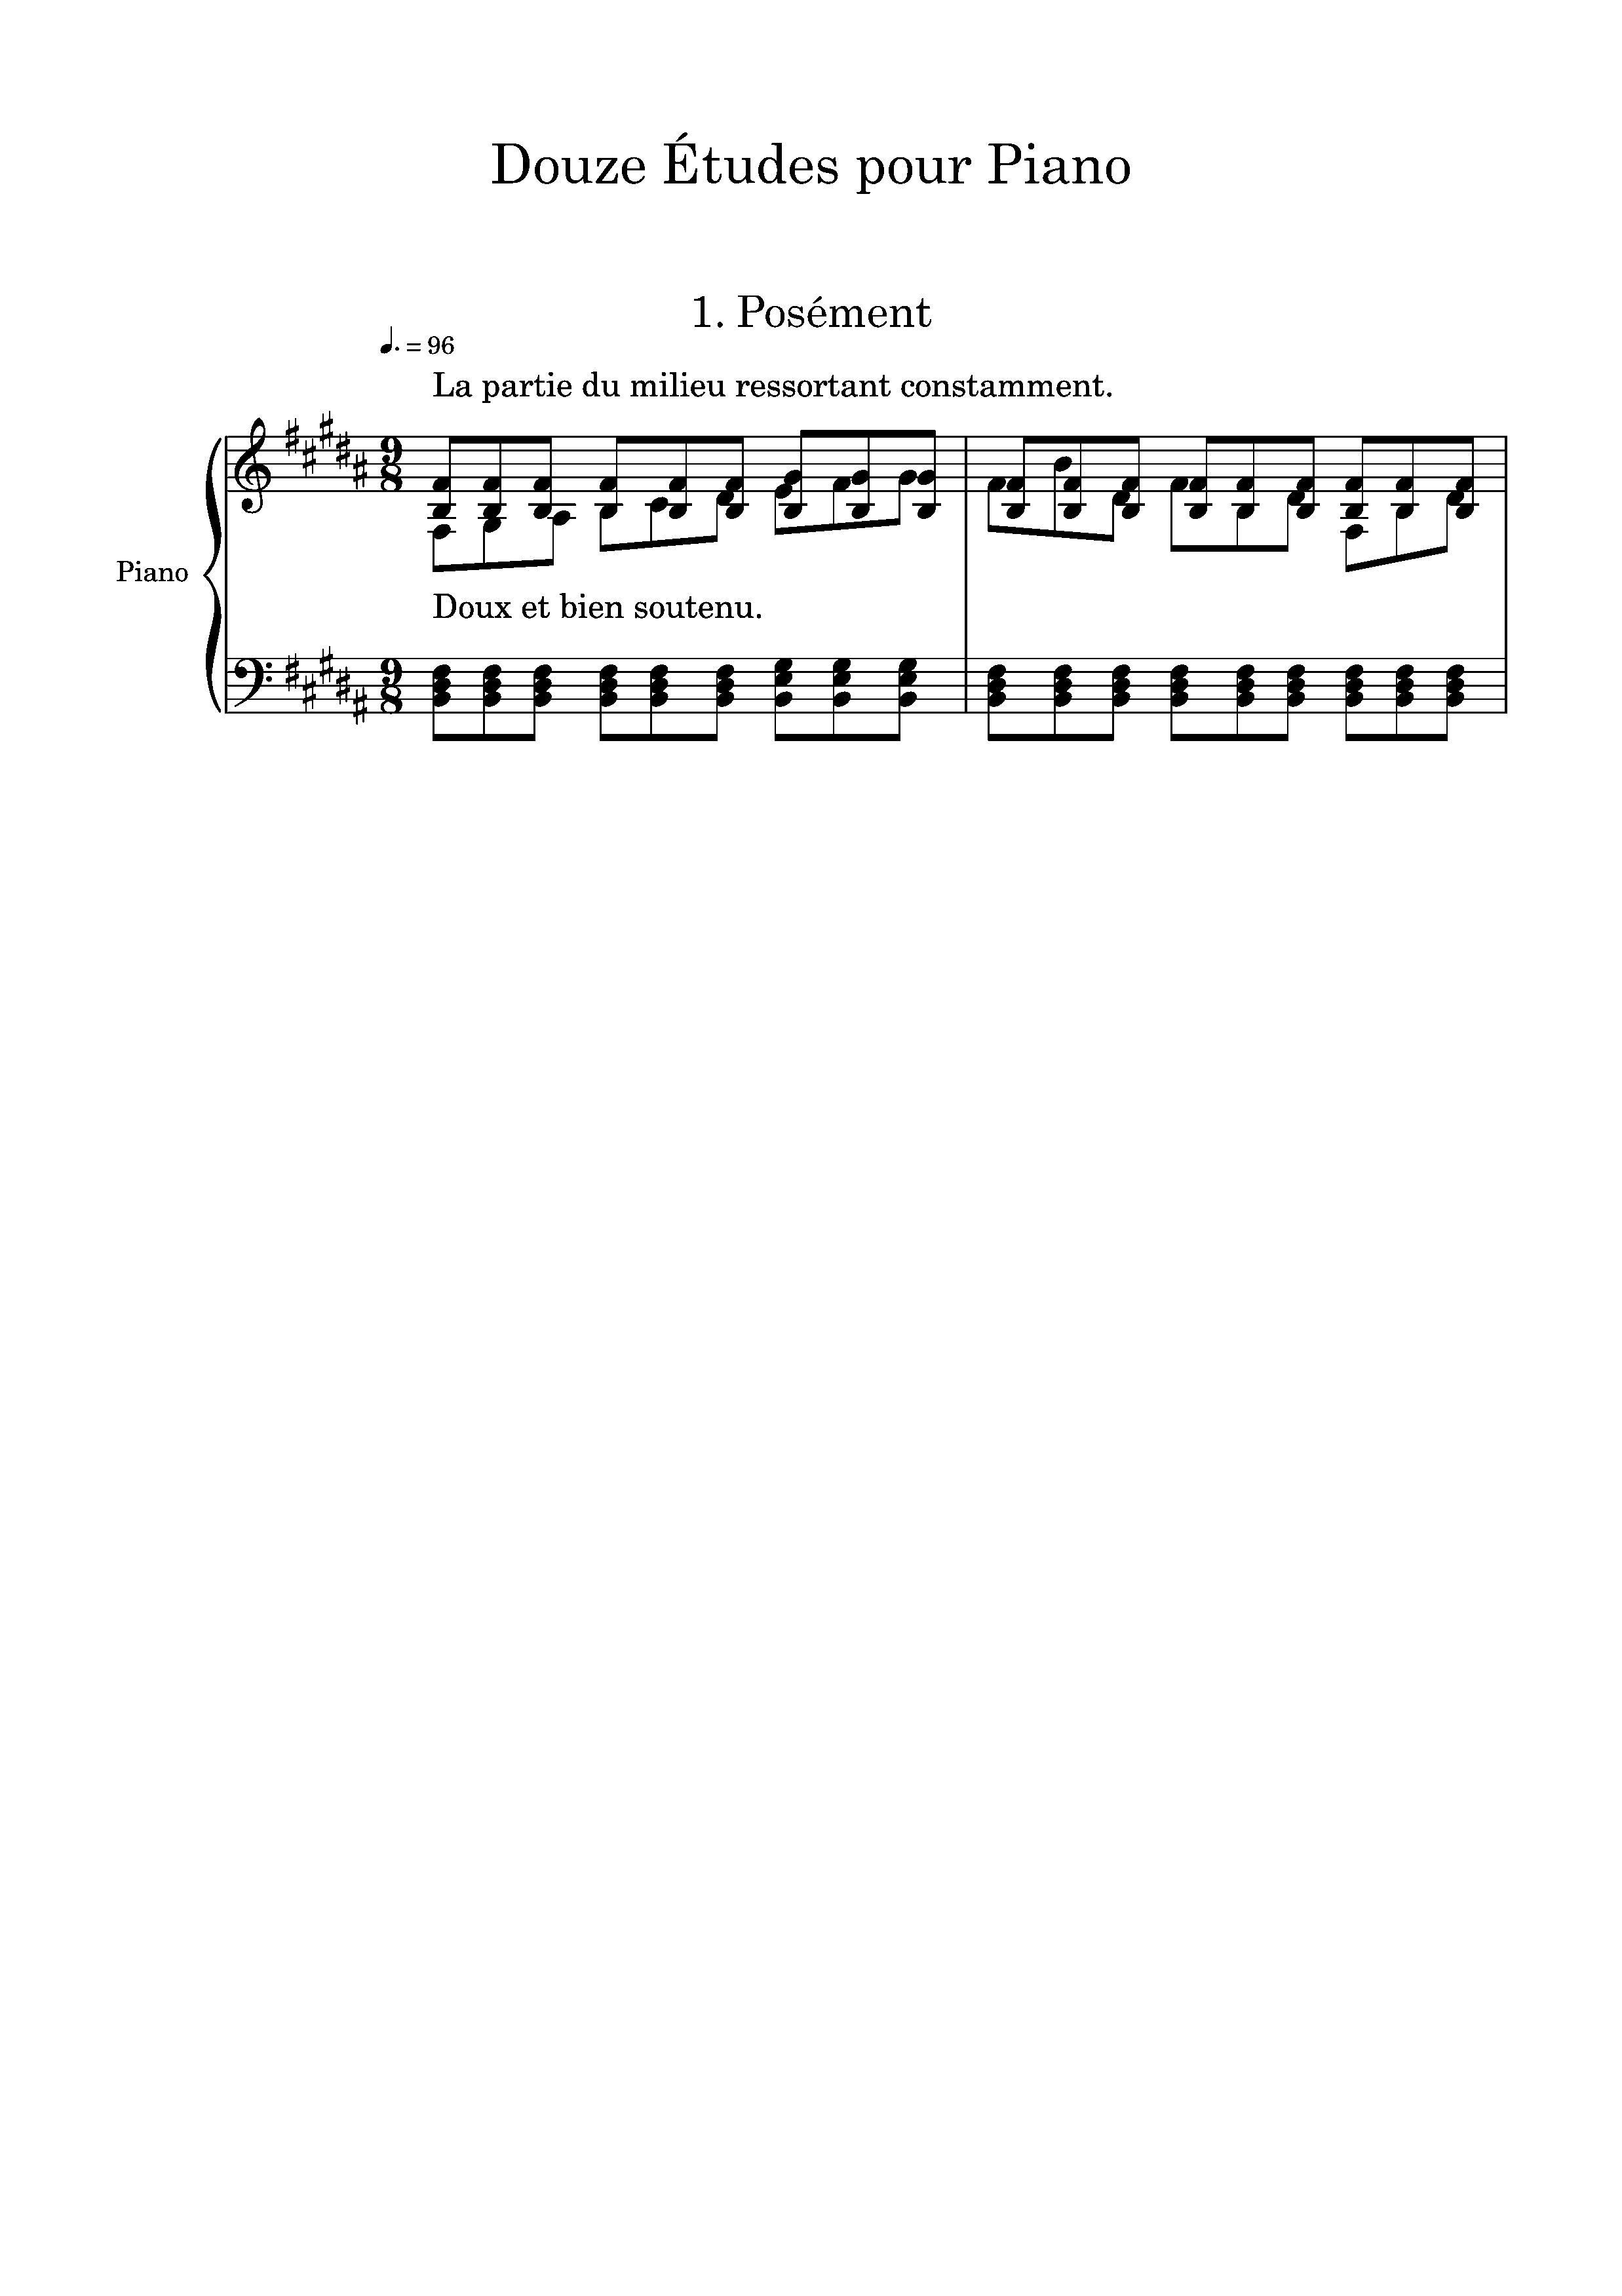

In [3]:
img_path = doremi_dir + 'Images/Alkan - Posement-001.png'
image = Image.open(img_path)
file_path = doremi_dir + 'Parsed_by_page_omr_xml/Parsed_Alkan - Posement-layout-0-muscima_Page_1.xml'
with open(file_path, 'r') as file:
    content = file.read(200)
    print(content)
image

## Staffline Extraction
First, we will extract stafflines. This step is the most important as the music scores are determined by their relative position to the stafflines. We will extract the following information for each staffline, which are fundamental for the later parts of this project. 

# Boundary Thought Process: 

In [4]:
class Staff:
    def __init__(self, center: float, upper_bound: int, lower_bound: int, unit_size: float, track: int):
        self.center = center
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.unit_size = unit_size
        self.track = track

    def __repr__(self):
        return (
            "Staff {\n"
            f"    Center: {self.center:.1f}\n"
            f"    Upper bound: {self.upper_bound}\n"
            f"    Lower bound: {self.lower_bound}\n"
            f"    Unit size: {self.unit_size:.1f}\n"
            f"    Track: {self.track}\n"
            "}"
        )

Staff {
    Center: 707.2
    Upper bound: 594
    Lower bound: 821
    Unit size: 20.8
    Track: 1
}
Staff {
    Center: 1045.4
    Upper bound: 933
    Lower bound: 1157
    Unit size: 20.5
    Track: 2
}


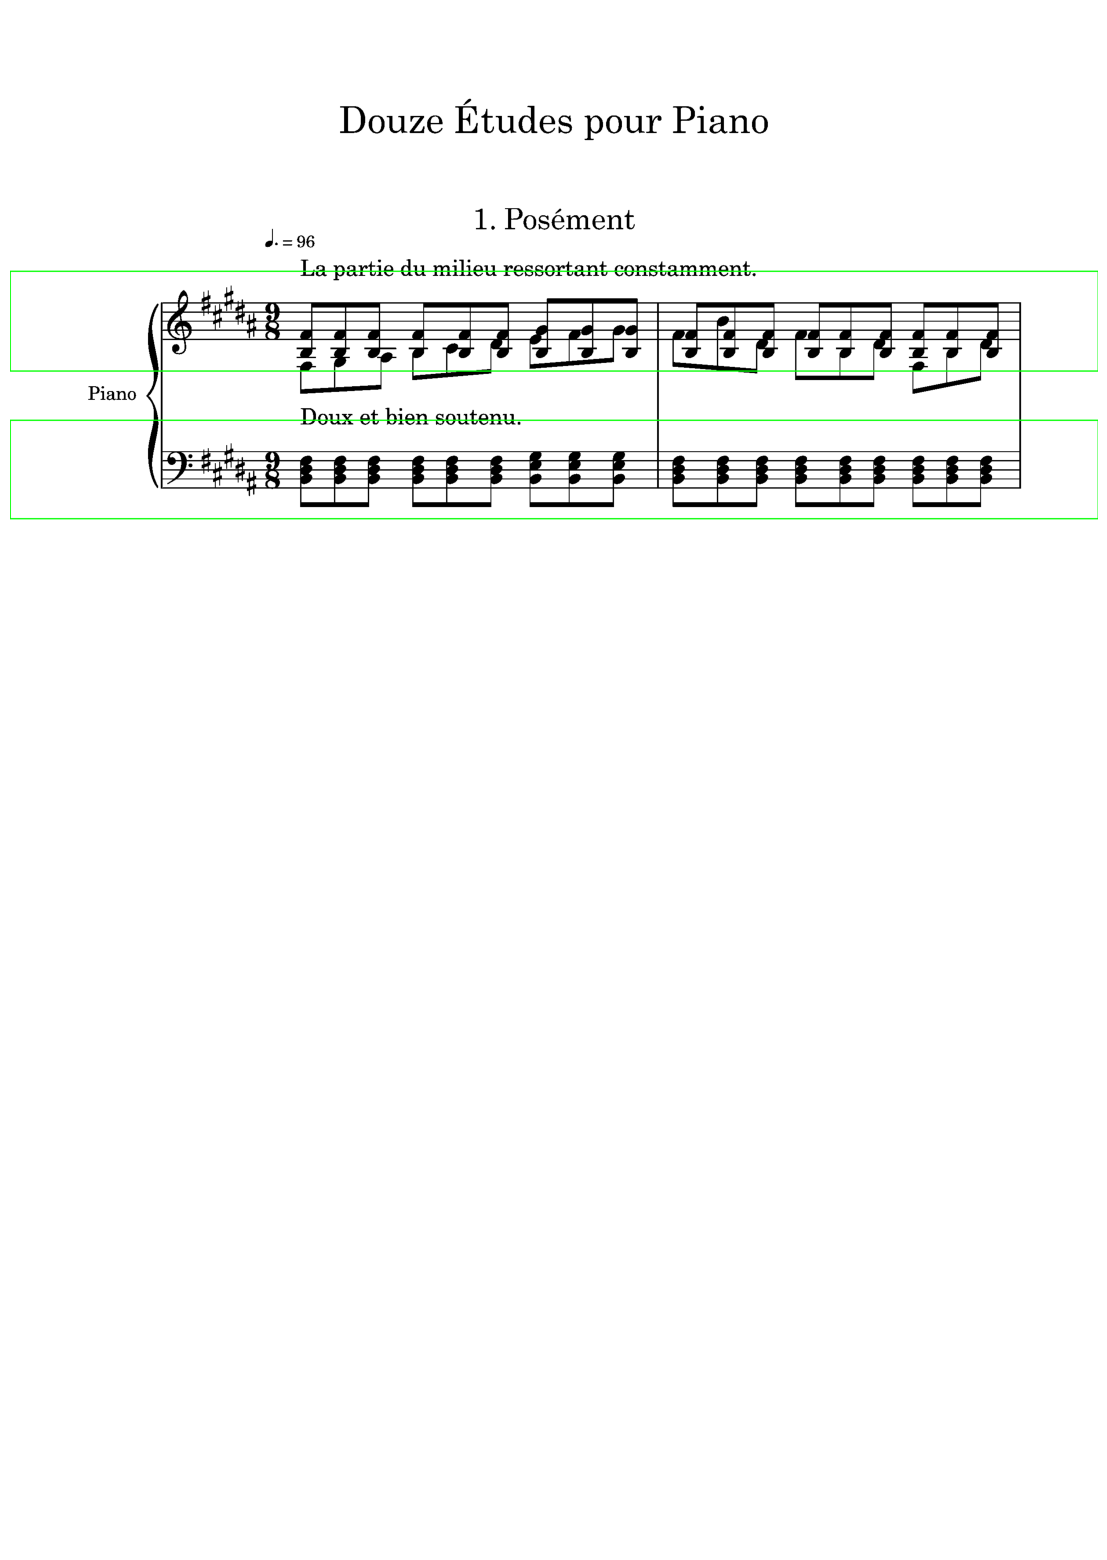

In [5]:
import cv2
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# Step 0: Convert grayscale
image_gray = image.convert("L")
image_np = np.array(image_gray)

# Step 1: Binarize image
_, binary = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step 2: Horizontal projection
horizontal_projection = np.sum(binary, axis=1)

# Step 3: Detect staffline peaks
peaks, _ = find_peaks(horizontal_projection, height=np.max(horizontal_projection) * 0.5, distance=5)

# Step 4: Group into staves (5 lines per group)
grouped_staffs = []
for i in range(0, len(peaks) - 4, 5):
    group = peaks[i:i+5]
    grouped_staffs.append(group)

# Step 5: Convert grayscale to RGB for drawing
image_color = np.stack([image_np]*3, axis=-1)

# Step 6: Draw bounding boxes and print structured output
staff_bounds = []
staff_bounds = []
staff_objects = []

for i, group in enumerate(grouped_staffs):
    y_center = float(np.mean(group))
    unit_size = float(np.mean(np.diff(group)))
    padding = int(unit_size * 3.5)

    y_min = int(np.min(group) - padding)
    y_max = int(np.max(group) + padding)
    track = i % 2 + 1

    staff = Staff(
        center=y_center,
        upper_bound=y_min,
        lower_bound=y_max,
        unit_size=unit_size,
        track=track
    )
    staff_objects.append(staff)
    staff_bounds.append((y_min, y_max))

    cv2.rectangle(image_color, (0, y_min), (image_np.shape[1], y_max), (0, 255, 0), 2)
    print(staff)


# Step 7: Show image with bounding boxes
plt.figure(figsize=(20, 20))
plt.imshow(image_color)
plt.axis("off")
plt.show()

# Extracting First 200 One Staff Images

In [6]:
import re
import pprint

def natural_key(string):
    return [int(s) if s.isdigit() else s.lower() for s in re.split('(\d+)', string)]

#Sorts Images and Parsed_by_page_omr_xml directories
image_list = os.listdir(doremi_dir+ "Images")
omr_xml_list =  os.listdir(doremi_dir + "Parsed_by_page_omr_xml")
image_list.sort(key=natural_key)
omr_xml_list.sort(key=natural_key)

#Matches each .png file to their respective omr_xml file
image_to_omr = {img: omr for img, omr in zip(image_list, omr_xml_list)}
#pprint.pprint(image_to_omr)

In [7]:
def extract_staffs_from_image(cropped_image, padding_multiplier=4.5):
    image_gray = cropped_image.convert("L")
    image_np = np.array(image_gray)
    _, binary = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    horizontal_projection = np.sum(binary, axis=1)
    peaks, _ = find_peaks(horizontal_projection, height=np.max(horizontal_projection) * 0.5, distance=5)

    grouped_staffs = []
    for i in range(0, len(peaks) - 4, 5):
        group = peaks[i:i+5]
        grouped_staffs.append(group)

    staff_objects = []
    for i, group in enumerate(grouped_staffs):
        y_center = float(np.mean(group))
        unit_size = float(np.mean(np.diff(group)))
        padding = int(unit_size * padding_multiplier)

        y_min = int(np.min(group) - padding)
        y_max = int(np.max(group) + padding)
        track = i % 2 + 1

        staff = Staff(
            center=y_center,
            upper_bound=y_min,
            lower_bound=y_max,
            unit_size=unit_size,
            track=track
        )
        staff_objects.append(staff)

    return staff_objects

In [8]:
from PIL import Image
import os

single_track_images = []
staff_data_per_image = {}

for image_name in image_list:
    image_path = os.path.join(doremi_dir, "Images", image_name)
    try:
        cropped_image = Image.open(image_path)
        staff_objects = extract_staffs_from_image(cropped_image)

        tracks = set(s.track for s in staff_objects)
        if tracks == {1}:  # Only track 1
            single_track_images.append(image_name)
            staff_data_per_image[image_name] = staff_objects  # store staff info

        if len(single_track_images) == 200:
            break
    except Exception as e:
        print(f"Skipping {image_name} due to error: {e}")
        continue

# Confirm results
print(f"\nFound {len(single_track_images)} single-track images.\n")


Found 200 single-track images.



To help see what those 200 1 staff images we are going to use look like, (ALSO HELPS IF WE WANT TO FILTER OUT ANY INDIVIDUAL DATA OR IMAGES)

In [9]:
max_height = 0
max_image_name = None
max_upper = None
max_lower = None

for image_name in single_track_images:
    image_path = os.path.join(doremi_dir + "Images", image_name)
    cropped_image = Image.open(image_path)

    staff_objects = extract_staffs_from_image(cropped_image)
    #print(staff_objects)
    if max_upper == None or staff_objects[0].upper_bound < max_upper:
        max_upper = staff_objects[0].upper_bound
    if max_lower == None or staff_objects[0].lower_bound > max_lower:
        max_lower = staff_objects[0].lower_bound

print(f"Upper bound: {max_upper}")
print(f"Lower bound: {max_lower}")

Upper bound: 319
Lower bound: 842


# OMR_XML Preprocessng

In [10]:
#To view an image [0,5217]
key_list = list(image_to_omr.keys())
image_path = os.path.join(doremi_dir, "Images", key_list[5217])
image = Image.open(image_path)
#image

In [11]:
class Note:
    def __init__(self, class_name: str, top: int, left: int, width: int, height: int):
        self.class_name = class_name
        self.top = top
        self.left = left
        self.width = width
        self.height = height
    def gather_coordinates(self):
        return [self.top, self.left, self.width, self.height]
    def create_box(self):
        return [(self.left, self.top), (self.left + self.width, self.top + self.height)]

In [12]:
import xml.etree.ElementTree as ET

image_to_notes = {}
for key in single_track_images:
# Parse the XML file
    xml_path = os.path.join(doremi_dir, "Parsed_by_page_omr_xml", image_to_omr[key])
    tree = ET.parse(xml_path) 
    root = tree.getroot()
# Define target classnames
    target_classes = {'noteheadBlack', 'noteheadHalf', 'noteheadWhole'}

# Collect matching nodes
    matching_nodes = []

# Loop through all <Node> elements
    for node in root.findall('.//Node'):
        class_name = node.find('ClassName')
        if class_name is not None and class_name.text in target_classes:
            matching_nodes.append(node)

# Print results
    final_notes = []
    for match in matching_nodes:
        note = Note(match.find("ClassName").text, int(match.find("Top").text), int(match.find("Left").text), int(match.find("Width").text), int(match.find("Height").text))
        final_notes.append(note)
    image_to_notes[key] = final_notes
#pprint.pprint(image_to_notes)

In [13]:
first_200_image_to_notes = {key: image_to_notes[key] for key in single_track_images if key in image_to_notes}

top = max_upper
bottom = max_lower
 
cropped_note_pairs = []
for i, img_name in enumerate(first_200_image_to_notes.keys()):
    image_path = os.path.join(doremi_dir + "Images", img_name)
    img = Image.open(image_path)
    width = img.width
    # Crop image to vertical slice (top to bottom)
    cropped = img.crop((0, top, width, bottom))
    image_notes = image_to_notes[img_name]
    for note in image_notes:
        note.top -= max_upper
    cropped_note_pairs.append((cropped, image_notes))

Validation of cropped_note_pairs, which takes the first 200 images and maps them to their processed omr_xml file

In [14]:
from PIL import Image, ImageDraw

#pprint.pprint(cropped_note_pairs)
#for i in range(200):
#     test_image, notes = cropped_note_pairs[i]
#     img = test_image.copy()  
#     draw = ImageDraw.Draw(img)
#
#     # Draw bounding boxes on the image
#     counter = 0;
#     for note in notes:
#        draw.rectangle(note.create_box(), outline="red", width=2)
#draw.text(note.create_box()[1], str(counter), fill="black")
#         counter += 1
#     display(img)
#     width, height = img.size
#     print(width)
 #    print(height)

#test_image, notes = cropped_note_pairs[0]
#img = test_image.copy()  
#sample_cropped_img = test_image

# Notehead Extraction

## Morphing

Here we are morphing the images using morphological operations, closing and opening kernels, to isolate the noteheads in the images. 

**Erosion**: Shrinks white regions and removes the small noise around them

**Dilation**: Expands white regions and fills in the small holes or gaps

**Opening**: Erosion then dilation

**Closing**: Dilation then erosion

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

WIDTH_FACTOR = 0.5
HEIGHT_FACTOR = 0.4
MIN_AREA = 150 # pixels

MAX_HEIGHT_WIDTH_RATIO = 2.0
MIN_WIDTH_HEIGHT_RATIO = 0.5  

def remove_staff_lines(binary_img: np.ndarray) -> np.ndarray:
    """
    Detect and remove horizontal staff lines from the binary image input. 

    Output: 
        np.ndarray: a binary image with horizontal staff lines removed.
    """
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
    detected_stafflines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    return cv2.subtract(binary_img, detected_stafflines)

def extract_noteheads(img_path, debug: bool, ellipse_size: int) -> np.ndarray:
    # convert image to grayscale
    # img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # testing with 'cropped_img' variable
    gray_img = img_path.convert('L')
    gray_img = np.array(gray_img, dtype=np.uint8)

    # assign all pixel values higher than 127 to 255 and others to 0
    _, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV)
    
    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(binary_img, cmap='gray')
        plt.title("Binary Inverted")
        plt.axis('off')
        plt.show()
        
    # remove staff lines
    processed_img = remove_staff_lines(binary_img)

    # Performing morphological operations
    w_close = max(1, int(round(ellipse_size * 0.2)))
    h_close = max(1, int(round(ellipse_size * 0.4)))
    close_krn = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (w_close, h_close))
    closed = cv2.morphologyEx(processed_img, cv2.MORPH_CLOSE, close_krn)

    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(closed, cmap='gray')
        plt.title("After Closed")
        plt.axis('off')
        plt.show()
           
    notehead_size = (
        int(round(ellipse_size * WIDTH_FACTOR)),
        int(round(ellipse_size * HEIGHT_FACTOR))
    )
    
    # erode away isolated pixels that are not note heads
    kernel_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, notehead_size)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_2)

    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(opened, cmap='gray')
        plt.title("After Opened")
        plt.axis('off')
        plt.show()

    # find contours
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if debug:
        canvas = cv2.cvtColor(opened, cv2.COLOR_GRAY2BGR)
        
        cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        
        plt.figure(figsize=(6,6))
        plt.imshow(canvas[...,::-1])
        plt.title(f'{len(contours)} contours found')
        plt.axis('off')
        plt.show()

    # filter out shapes that are not noteheads by checking how round the white area is
    notehead_mask = np.zeros_like(opened)
    for item in contours:
        area = cv2.contourArea(item)
        # print(area)
        if area < MIN_AREA:
            continue
            
        x, y, w, h = cv2.boundingRect(item)
        
        # Drop any blob that's too tall/thin:
        if h / float(w) > MAX_HEIGHT_WIDTH_RATIO:
            continue

        # Drop any blob that's too wide/flat:
        if w / float(h) < MIN_WIDTH_HEIGHT_RATIO:
            continue
            
        cv2.drawContours(notehead_mask, [item], -1, 255, -1)

    morphed = notehead_mask

    if debug:
        plt.figure(figsize=(6,6))
        plt.imshow(morphed, cmap='gray')
        plt.title("Morphed (staff lines out, noteheads closed)")
        plt.axis('off')
        plt.show()
        
    final_contours, _ = cv2.findContours(
        notehead_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    return morphed, final_contours

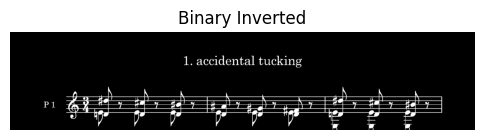

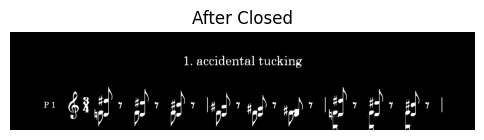

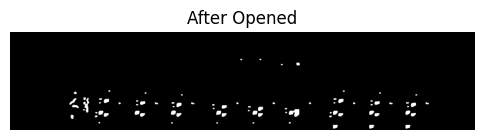

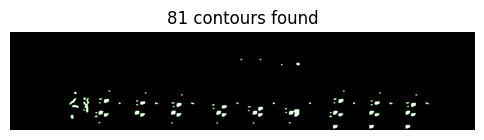

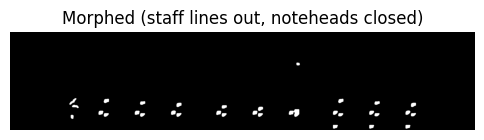

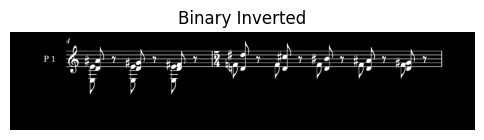

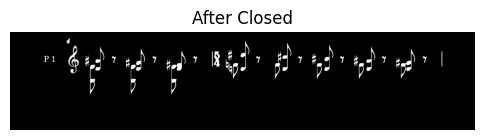

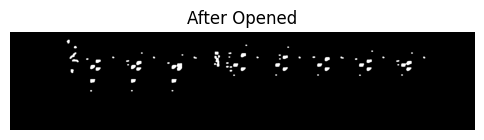

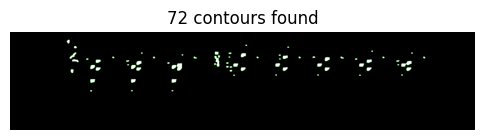

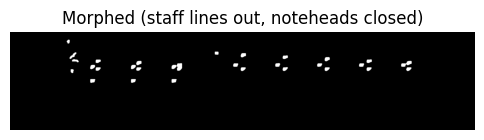

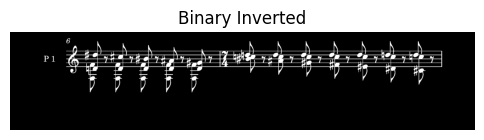

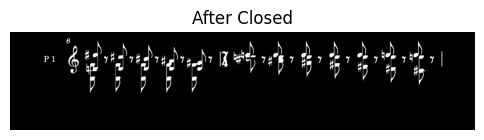

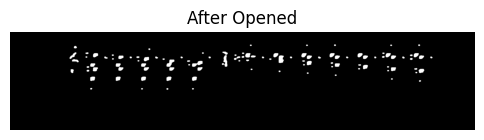

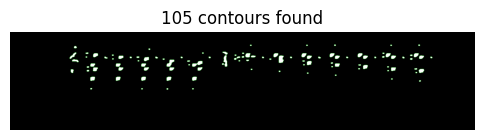

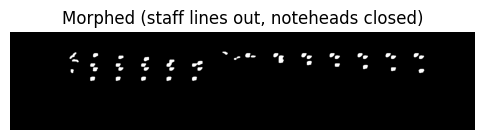

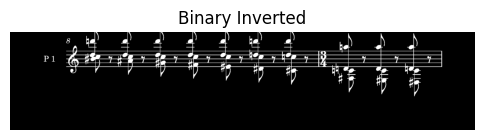

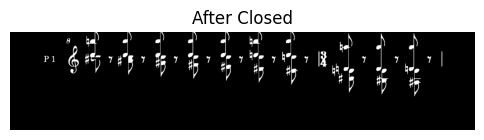

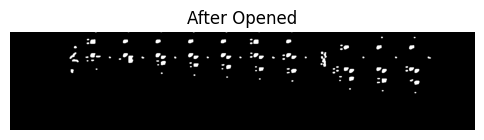

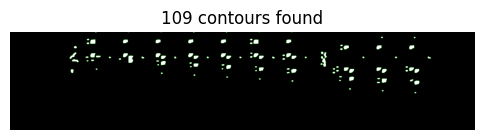

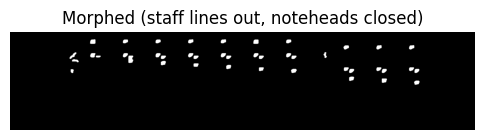

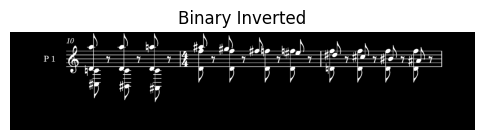

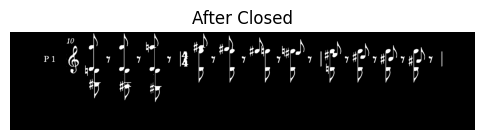

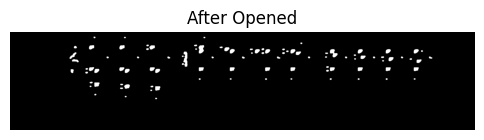

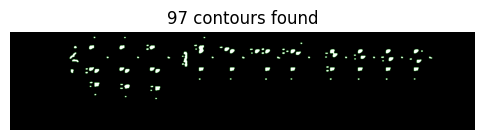

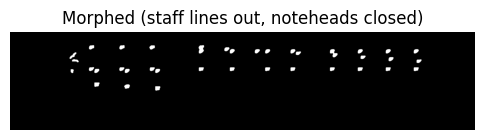

In [16]:
img_contours = []
for i in range(5):
    test_image, notes = cropped_note_pairs[i]    
    morphed, contours = extract_noteheads(test_image, True, 20.5)
    img_contours.append(contours)

In [17]:
# CONSTANTS
PAD = 4
MAX_AREA = 500 # max area of a notehead

### Helper Functions

These are two helper functions.

`get_rooi_coords` basically computes the bounding box by caclulating the smallest bounding box that encloses teh entire region. In a way, it zooms into the image. Mainly used for debugging purposes

`split_horizontal_blob`takes in an image and splits it into two halves horizontally. 

In [18]:
def get_roi_coords(mask):
    """
    Compute padded bounding-box coordinates for a binary mask.
    Returns (x0, y0, x1, y1).
    """
    x, y, w, h = cv2.boundingRect(mask)
    # make sure we don't go out of bounds
    x0 = max(0, x - PAD) 
    y0 = max(0, y - PAD)
    x1 = min(mask.shape[1], x + w + PAD)
    y1 = min(mask.shape[0], y + h + PAD)
    return x0, y0, x1, y1

def split_horizontal_blob(mask, debug=False):
    """
    Split a single-blob mask horizontally through its vertical midpoint.
    Returns [top_half, bottom_half] or [mask] if one half is empty.
    """
    # Compute bounding box
    x, y, w, h = cv2.boundingRect(mask)
    mid_y = y + h // 2 # calculating the midway point

    # Empty masks
    top = np.zeros_like(mask)
    bottom = np.zeros_like(mask)

    # Slicing within bbox
    top[y:mid_y, x:x+w] = mask[y:mid_y, x:x+w]
    bottom[mid_y:y+h, x:x+w] = mask[mid_y:y+h, x:x+w]
    pieces = [top, bottom]

    # If one half is empty, return original. This means that either mask is completely all black
    if cv2.countNonZero(top) == 0 or cv2.countNonZero(bottom) == 0:
        return [mask]

    # Creating a kernel
    radius = 5
    ksize = 2 * radius + 1
    kern  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))

    # apply opening to each piece to erode straight edges, then dilate back
    # basically erosding away the straight edges and then dilating again to give it its shape back
    rounded = [cv2.morphologyEx(p, cv2.MORPH_OPEN, kern) for p in pieces]

    if debug:
        for i, m in enumerate(rounded):
            x0, y0, x1, y1 = get_roi_coords(mask)
            plt.figure(figsize=(3,3))
            plt.imshow(m[y0:y1, x0:x1], cmap='gray')
            plt.title(f'Rounded Piece #{i}')
            plt.axis('off')
        plt.show()

    return rounded

### Watershed

An algorithm for image segmentation. Basically splits image into distinct regions, flooding images from the "seeds". 

[What is Watershed?](https://www.perplexity.ai/search/what-is-the-watershed-algorith-mNzE8VcRTUyQ6K.sGpDwtg#0)

### Split Blob

This function splits blobs into smaller ones by using the water shed algorithm.
1. Computing distance transform. Here, it is computing the shortest distance from the foreground pixel to the background pixel (for each pixel in the binary image). This is to help idenitfy foreground pixels vs background pixel
2. Sure foreground peaks. Here it is extracting pixels from the previous step that are a certain threshold, currently `40%`, from the background. Basically, pixels larger than thise threshold are for sure foreground pixels.
3. Creating markers. With the foreground regions isolated, we can mark them with markers as seeds, setting up for the flooding in the water shed algorithm
4. Watershed algorithm.

In [19]:
def split_blob(mask, debug=False):
    """
    Split a large binary mask into smaller ones using watershed,until each piece's nonzero area <= MAX_AREA.
    Returns a list of mask pieces.
    """
    # If this mask is already small enough, return it. Error checking bascially
    area = cv2.countNonZero(mask)
    if area <= MAX_AREA:
        if debug:
            x0, y0, x1, y1 = get_roi_coords(mask)
            plt.figure(figsize=(4,4))
            plt.imshow(mask[y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
            plt.title(f'Final Piece (area={area})')
            plt.axis('off')
        return [mask]

    # 1) Compute distance transform
    # Computes shortest distance from foreground pixel to the background pixel. Identifying the center regions of the object
    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    if debug:
        x0, y0, x1, y1 = get_roi_coords(mask)

        plt.figure(figsize=(4,4))
        plt.imshow(dist[y0:y1, x0:x1], cmap='viridis', interpolation='nearest')
        plt.title('Distance Transform')
        plt.axis('off')

    # 2) Get sure foreground peaks (areas that are confidently park of the foreground, deep enough within the object)
    # Extracting deepest pixels from background boundary, 40% of blob distance
    thresh_val = 0.6 * dist.max()
    _, fg = cv2.threshold(dist, thresh_val, 255, cv2.THRESH_BINARY)
    fg = fg.astype(np.uint8) # converting to be used in OpenCV
    if debug:
        x0, y0, x1, y1 = get_roi_coords(mask)

        plt.figure(figsize=(4,4))
        plt.imshow(fg[y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
        plt.title('Sure Foreground Peaks')
        plt.axis('off')

    # 3) Create markers for watershed
    num_components, markers = cv2.connectedComponents(fg)
    if num_components < 2: # only one component in the foreground
        return [mask]
    markers = markers + 1 # 0 is reserved for the background
    unknown = cv2.subtract(mask, fg) # marking the unknown region
    markers[unknown == 255] = 0 # uncertain pixels
    
    if debug:
        x0, y0, x1, y1 = get_roi_coords(mask)

        plt.figure(figsize=(4,4))
        plt.imshow(markers[y0:y1, x0:x1], cmap='tab20', interpolation='nearest')
        plt.title('Watershed Markers')
        plt.axis('off')

    # 4) Apply watershed
    color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR) # watershed needs a colored image
    cv2.watershed(color, markers) # running watershed, flooding from seed labels
    
    if debug:
        boundary_overlay = color.copy()
        boundary_overlay[markers == -1] = (0,0,255)
        x0, y0, x1, y1 = get_roi_coords(mask)

        plt.figure(figsize=(4,4))
        plt.imshow(boundary_overlay[y0:y1, x0:x1][..., ::-1], interpolation='nearest')
        plt.title('Watershed Boundaries ')
        plt.axis('off')

    # 5) Extract pieces
    pieces = []
    for lbl in range(2, num_components+1):
        piece = np.zeros_like(mask)
        piece[markers == lbl] = 255
        if cv2.countNonZero(piece) > 0:
            if debug:
                x0, y0, x1, y1 = get_roi_coords(piece)
                plt.figure(figsize=(4,4))
                plt.imshow(piece[y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
                plt.title(f'Piece {lbl-1}')
                plt.axis('off')
            pieces.append(piece)

    # If watershed didn't split, return original
    if not pieces:
        return [mask]
        
    aspect_thresh = 1.2 # height has to be 120% of width, if its greater, that means there are two notes on top of each other
    pieces = []
    
    for lbl in range(2, num_components+1):
        piece = np.zeros_like(mask)
        piece[markers == lbl] = 255
        if cv2.countNonZero(piece) > 0:
            # checking aspect ratio
            x,y,w,h = cv2.boundingRect(piece)
                
            if h > w * aspect_thresh or h * aspect_thresh > w:
                if True:
                    x0, y0, x1, y1 = get_roi_coords(piece)
                    plt.figure(figsize=(4,4))
                    plt.imshow(piece[y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
                    plt.title(f'Piece {lbl-1} height: {h}, width: {w}')
                    plt.axis('off')
                # split horizontally if its too tall or too wide
                sub = split_horizontal_blob(piece, True)
                pieces.extend(sub)
            else:
                if debug:
                    x0, y0, x1, y1 = get_roi_coords(piece)
                    plt.figure(figsize=(4,4))
                    plt.imshow(piece[y0:y1, x0:x1], cmap='gray', vmin=0, vmax=255, interpolation='nearest')
                    plt.title(f'Piece {lbl-1} (zoomed)'); plt.axis('off')
                pieces.append(piece)
    return pieces

In [20]:
import cv2
import numpy as np

def refine_and_fit_ellipses(gray_img, notehead_mask, contours,
                            iou_thresh=0.75,
                            min_area=150,
                            min_ellipse_area=300,
                            min_minor_axis=10,
                            min_axis_ratio=0.5,
                            min_area_ratio=0.6,
                            MAX_AREA_ratio=1.3,
                            min_solidity=0.75,
                            debug=False):
    """
    Returns two lists:
     - accepted: [( (cx,cy), (MA,ma), angle ), ... ]
     - rejected: [ ( (cx,cy), reason_string ), ... ]
    """
    H, W = gray_img.shape
    accepted, rejected = [], []
    MAX_AREA = 500

    for cnt in contours:
        # Computing the raw area
        rawA = cv2.contourArea(cnt)
        blob = np.zeros_like(notehead_mask)
        cv2.drawContours(blob, [cnt], -1, 255, -1)
        
        if debug:
            x0, y0, x1, y1 = get_roi_coords(blob)
            
            plt.figure(figsize=(4,4))
            plt.imshow(blob[y0:y1, x0:x1],
                       cmap='gray',
                       vmin=0, vmax=255,
                       interpolation='nearest')
            plt.title("Blob mask")
            plt.axis('off')

        # If raw area is bigger than the max area, split into multple blobs
        if rawA > MAX_AREA:
            submasks = split_blob(blob, False)
        else:
            submasks = [blob]

        for piece in submasks:
            # extracting pieces from the submask and adding PADding 
            x0, y0, x1, y1 = get_roi_coords(piece)

            roi_gray = gray_img[y0:y1, x0:x1]
            roi_mask = piece[y0:y1, x0:x1]
            
            if debug:
                plt.figure(figsize=(4,4))
                plt.imshow(roi_gray,
                           cmap='gray',
                           vmin=0, vmax=255,
                           interpolation='nearest')
                plt.title("ROI gray")
                plt.axis('off')
                
                plt.figure(figsize=(4,4))
                plt.imshow(roi_mask,
                           cmap='gray',
                           vmin=0, vmax=255,
                           interpolation='nearest')
                plt.title("ROI mask")
                plt.axis('off')
                
            # finding the local contours within the mask
            local_cnts, _ = cv2.findContours(
            roi_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            # Run 9 total tests
            for lc in local_cnts:
                area = cv2.contourArea(lc)
                cx_loc, cy_loc = cv2.boundingRect(lc)[:2]
                (cx_loc, cy_loc), (MA, ma), ang = cv2.fitEllipse(lc)
                # 1) raw-area floor
                if area < min_area:
                    rejected.append(((cx_loc+x0, cy_loc+y0),(MA,ma),ang))
                    continue

                # 2) need at least 5 points to fit an ellipse
                if len(lc) < 5:
                    rejected.append(((cx_loc+x0, cy_loc+y0),(MA,ma),ang))
                    continue

                # 4) ellipse-area floor
                ell_area = np.pi*(MA/2)*(ma/2)
                if ell_area < min_ellipse_area:
                    rejected.append(((cx_loc+x0, cy_loc+y0),(MA,ma),ang))
                    continue

                # 5) minor-axis floor
                if min(MA, ma) < min_minor_axis:
                    rejected.append(((cx_loc+x0, cy_loc+y0),(MA,ma),ang))
                    continue

                # 6) axis-ratio
                axis_r = min(MA,ma)/max(MA,ma)
                if axis_r < min_axis_ratio:
                    rejected.append(((cx_loc+x0, cy_loc+y0),(MA,ma),ang))
                    continue

                # 7) area-ratio
                area_r = area/ell_area
                if not (min_area_ratio <= area_r <= MAX_AREA_ratio):
                    rejected.append(((cx_loc+x0, cy_loc+y0),(MA,ma),ang))
                    continue

                # 8) solidity
                hull = cv2.convexHull(lc)
                hull_area = cv2.contourArea(hull)
                solidity = area/hull_area if hull_area>0 else 0
                if solidity < min_solidity:
                    rejected.append(((cx_loc+x0, cy_loc+y0),(MA,ma),ang))
                    continue

                # 9) IoU
                ell_mask = np.zeros_like(roi_mask)
                cv2.ellipse(ell_mask, ((cx_loc,cy_loc),(MA,ma),ang),
                        color=255, thickness=-1)
                inter = np.logical_and(roi_mask>0, ell_mask>0).sum()
                union= np.logical_or (roi_mask>0, ell_mask>0).sum()
                iou = inter/union if union>0 else 0
                if iou < iou_thresh:
                    rejected.append(((cx_loc+x0, cy_loc+y0),(MA,ma),ang))
                    continue

                # 10) Original image similarity
                ell_mask = np.zeros_like(roi_mask)
                cv2.ellipse(
                    ell_mask,
                    ((cx_loc, cy_loc), (MA, ma), ang),
                    color=255,
                    thickness=-1
                )
                roi_blur = cv2.GaussianBlur(roi_gray, (5,5), 0)  # optional, for cleaner threshold
                _, roi_thresh = cv2.threshold(roi_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                # Logical XOR: counts where they differ
                diff = cv2.bitwise_xor(roi_thresh, ell_mask)
                diff_pixels = cv2.countNonZero(diff)
                diff_ratio = diff_pixels / (np.pi*(MA/2)*(ma/2))
                if diff_ratio < 0.95: 
                    rejected.append(((cx_loc+x0, cy_loc+y0), (MA,ma), ang))
                    continue
                # if we get here, it’s a keeper
                accepted.append(((cx_loc+x0, cy_loc+y0),(MA,ma),ang))

    return accepted, rejected

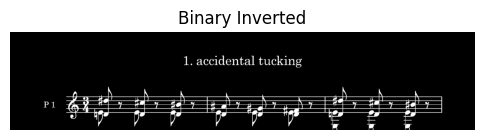

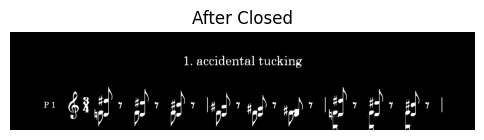

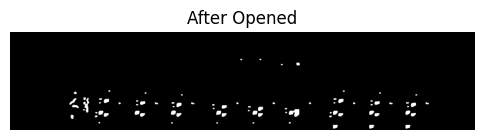

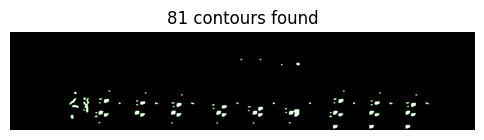

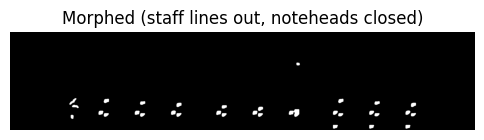

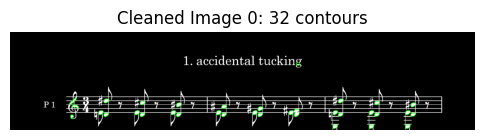

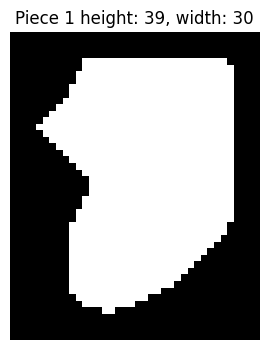

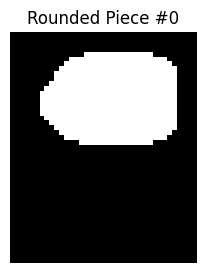

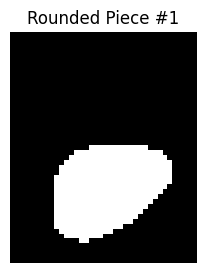

Accepted: 30 ellipses
Rejected: 4 blobs


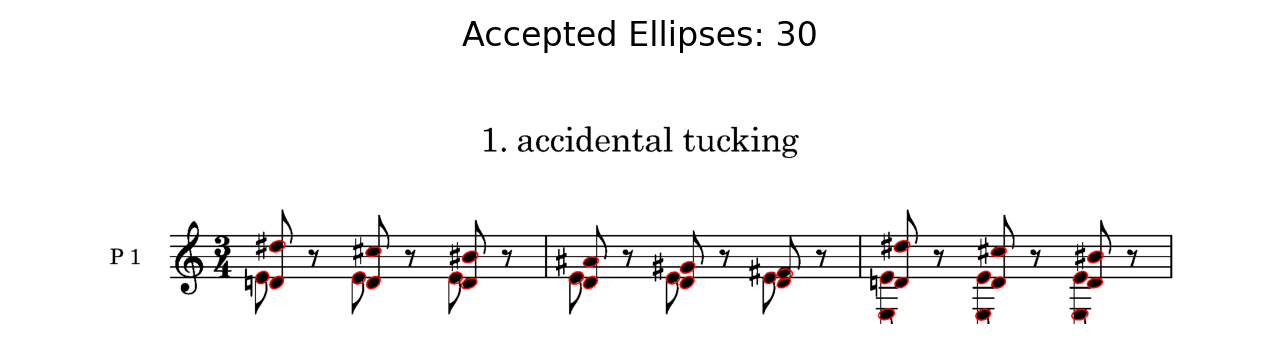

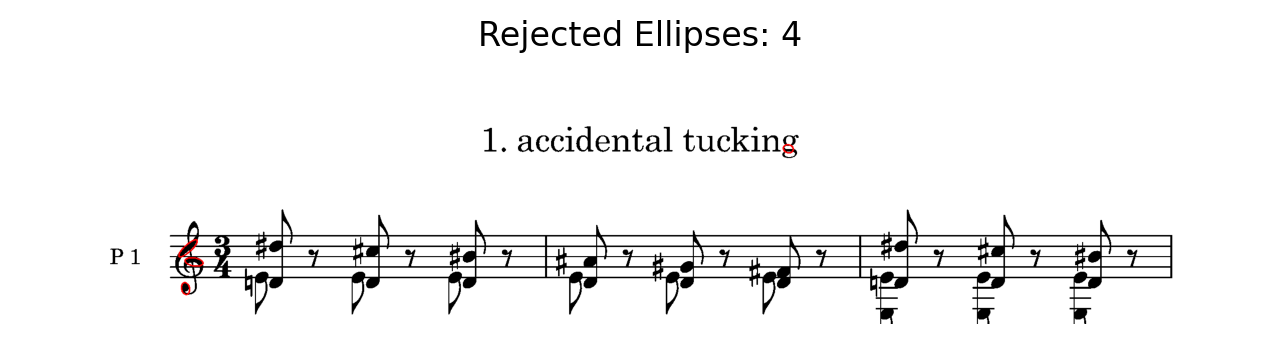

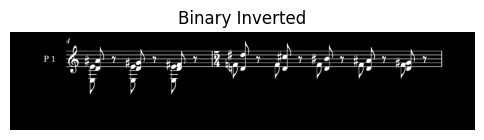

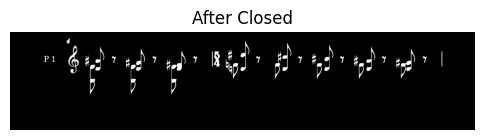

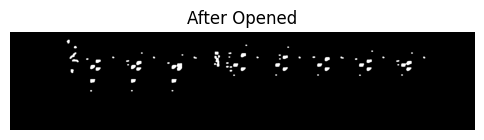

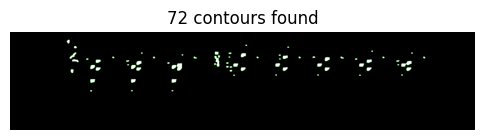

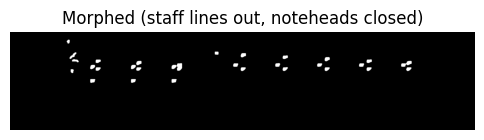

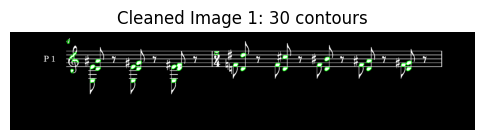

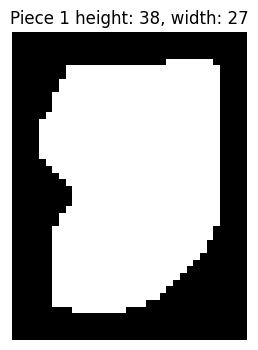

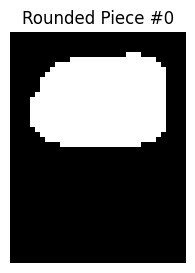

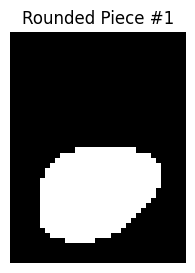

Accepted: 27 ellipses
Rejected: 5 blobs


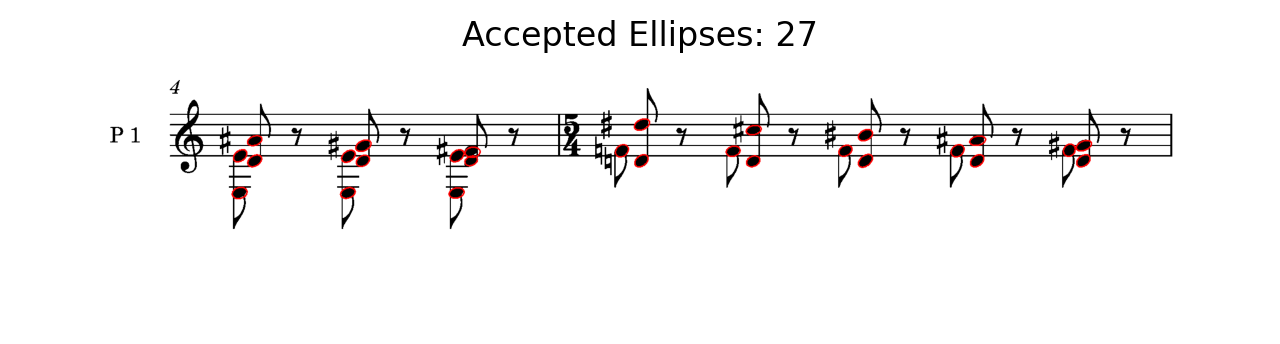

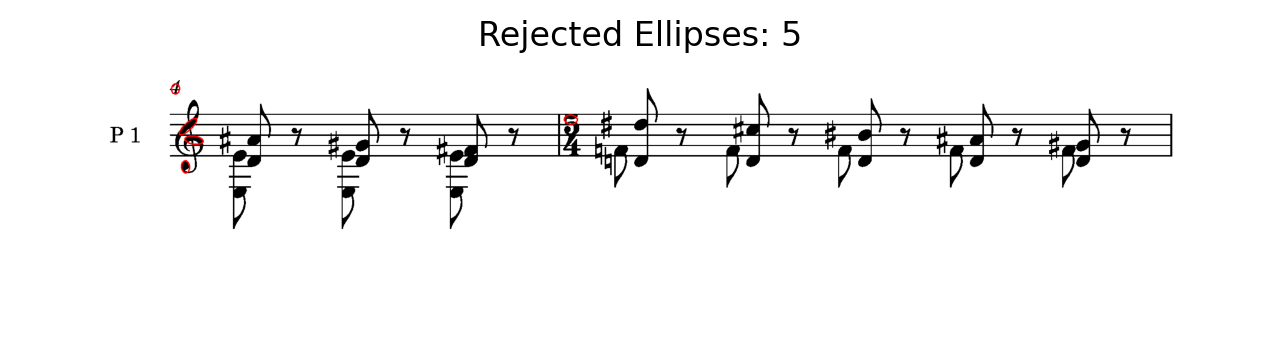

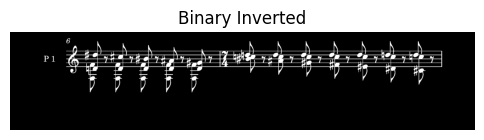

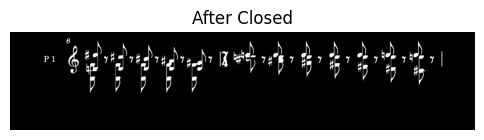

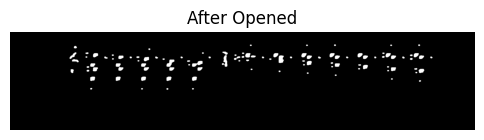

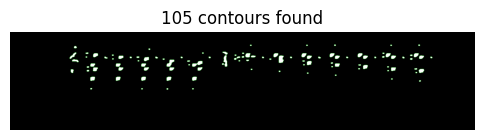

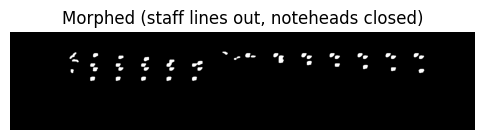

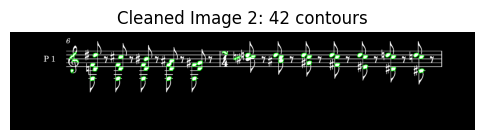

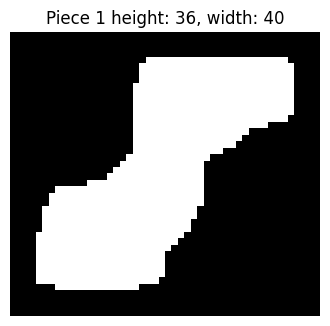

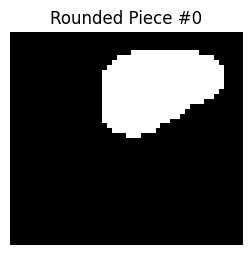

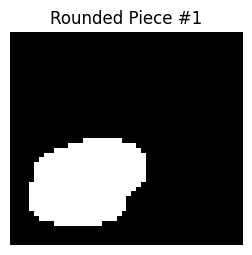

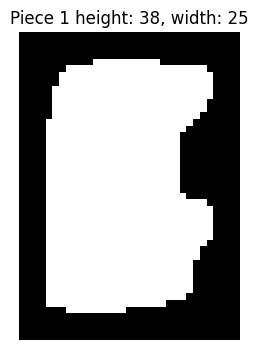

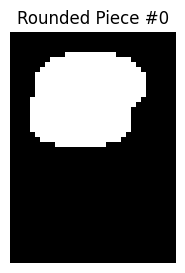

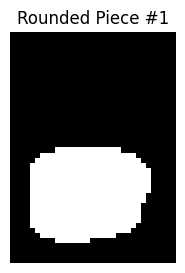

Accepted: 39 ellipses
Rejected: 6 blobs


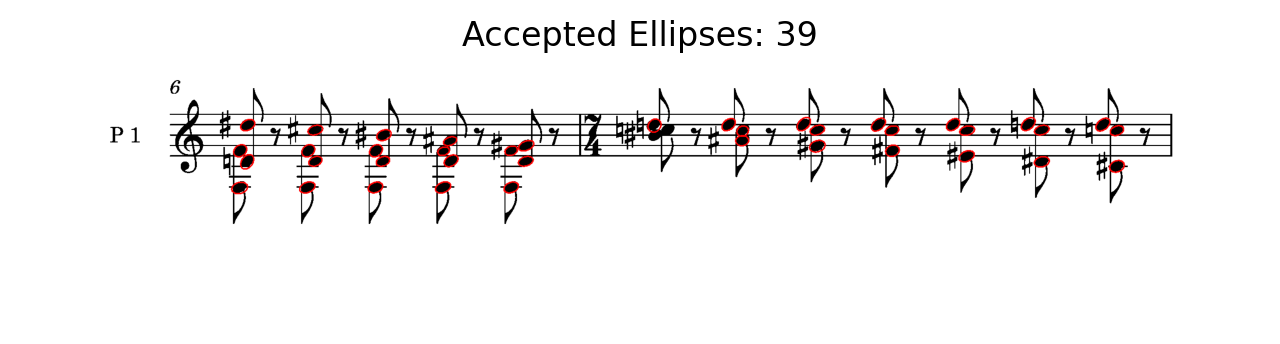

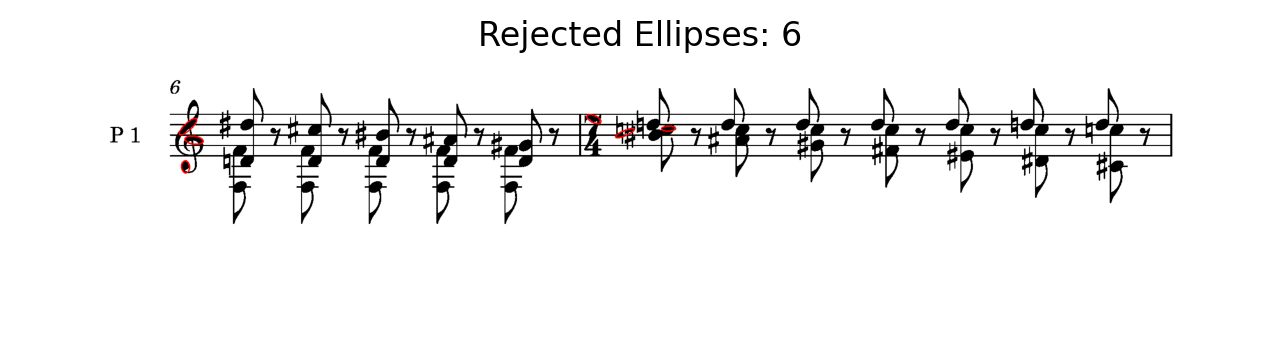

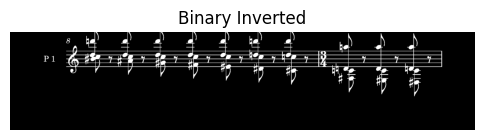

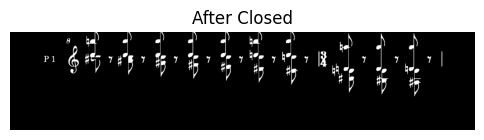

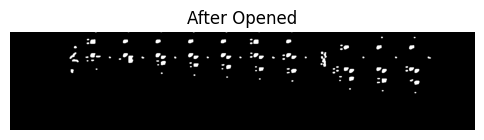

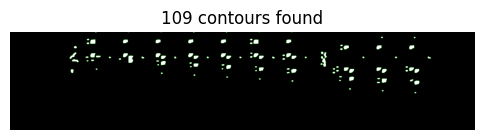

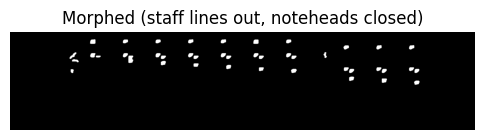

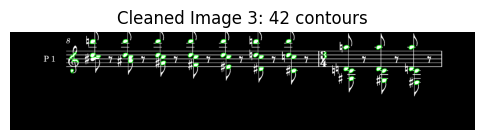

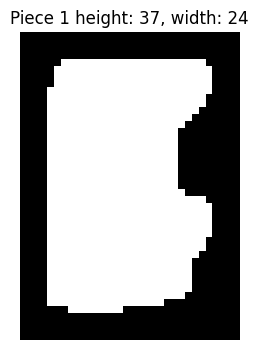

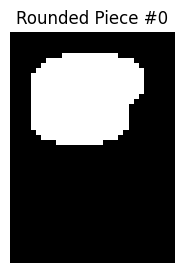

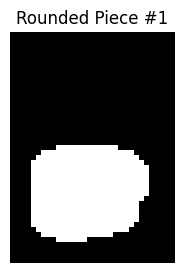

Accepted: 38 ellipses
Rejected: 5 blobs


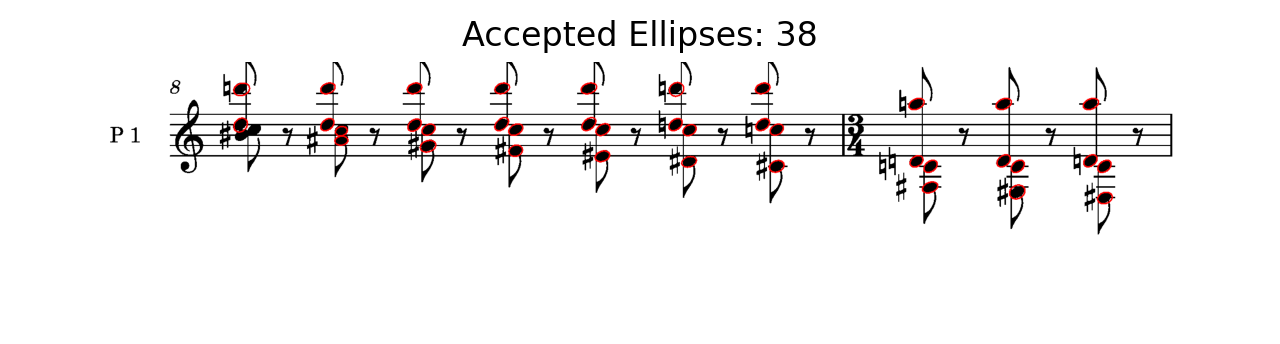

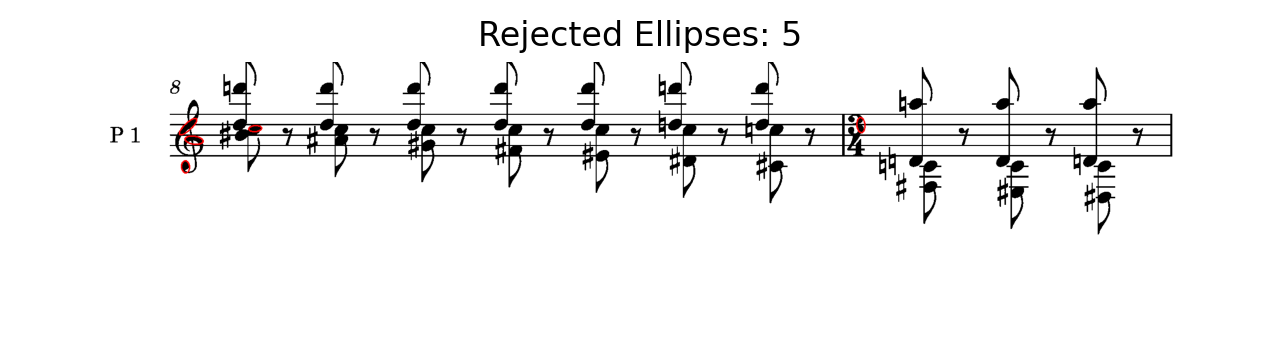

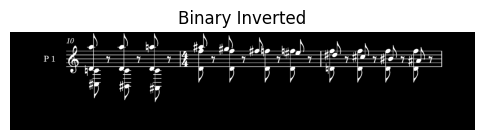

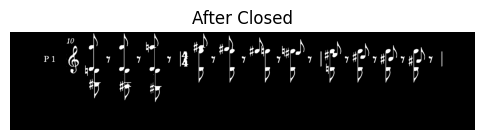

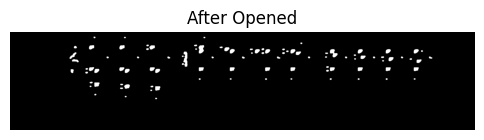

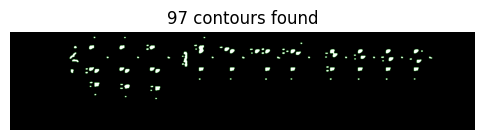

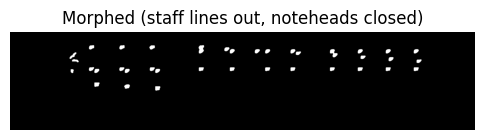

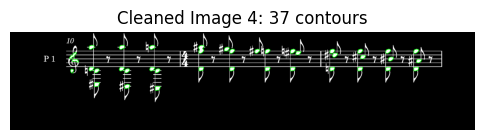

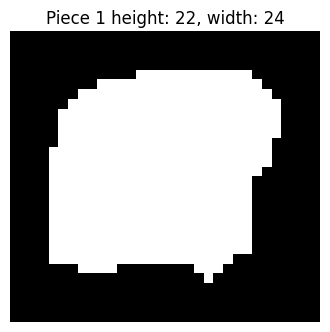

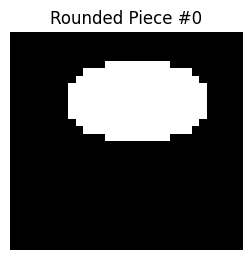

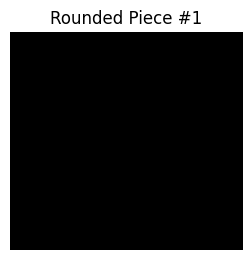

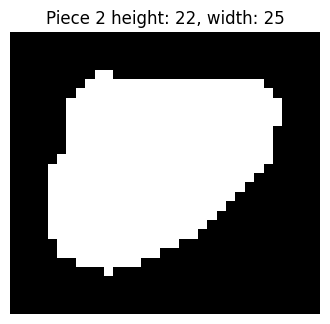

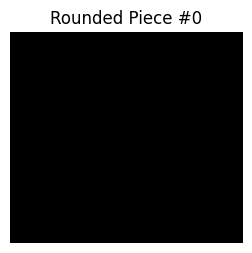

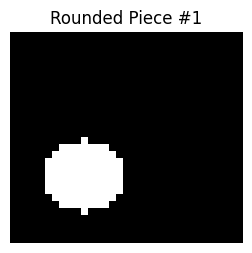

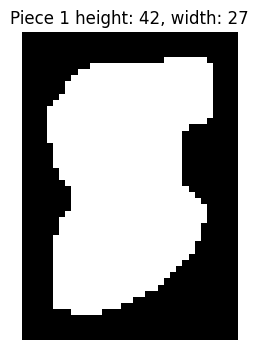

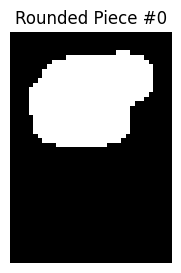

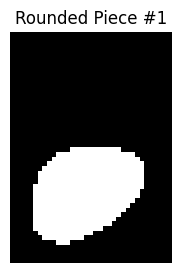

Accepted: 34 ellipses
Rejected: 5 blobs


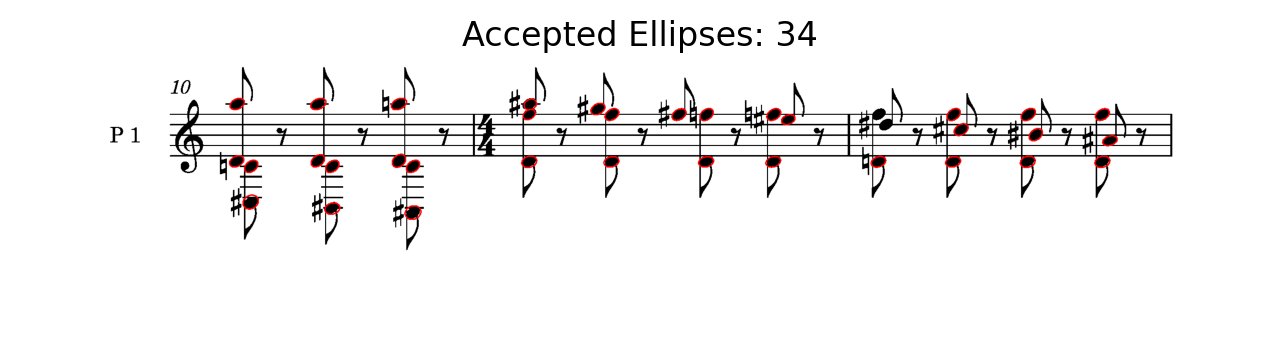

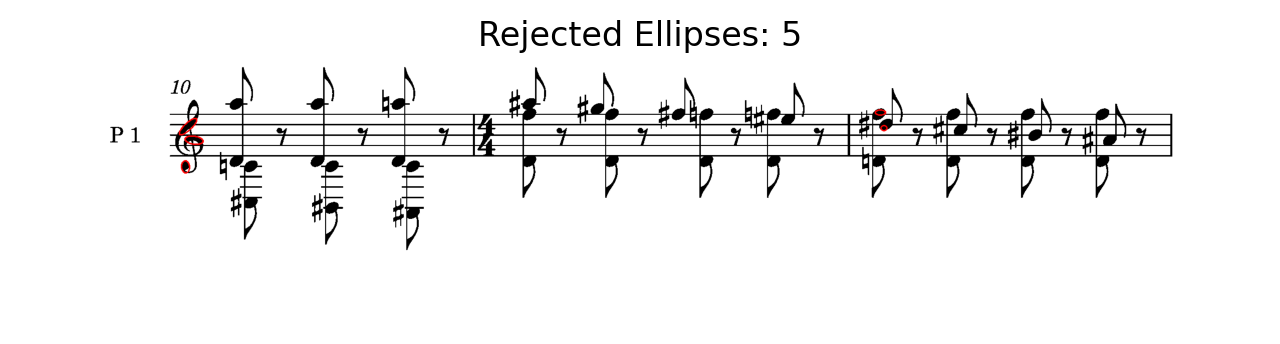

In [21]:
 for i in range(5):
    test_img, notes = cropped_note_pairs[i]

    # 1) Make image gray & binary
    if not isinstance(test_img, np.ndarray):
        gray = np.array(test_img.convert('L'), dtype=np.uint8)
    else:
        gray = test_img.astype(np.uint8)

    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

    # 2) Extract noteheads
    morphed, contours = extract_noteheads(
        test_img,
        ellipse_size=20,
        debug=True
    )

    # 3) Visualize the cleaned contours
    canvas = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(canvas, contours, -1, (0,255,0), 2)
    plt.figure(figsize=(6,6))
    plt.imshow(canvas[..., ::-1])
    plt.title(f"Cleaned Image {i}: {len(contours)} contours")
    plt.axis('off')
    plt.show()

    # 4) Now call the new fitter
    accepted, rejected = refine_and_fit_ellipses(
        gray_img = gray,
        notehead_mask = morphed,
        contours = contours,
        iou_thresh = 0.75,
        min_area = MIN_AREA,
        debug = False
    )
    
    print(f"Accepted: {len(accepted)} ellipses")
    print(f"Rejected: {len(rejected)} blobs")

    # 5) Overlay the kept ellipses on your original
    canvas2 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    for (cx,cy), (MA,ma), ang in accepted:
        cv2.ellipse(
            canvas2,
            (int(round(cx)), int(round(cy))),
            (int(round(MA/2)), int(round(ma/2))),
            angle=ang,
            startAngle=0,
            endAngle=360,
            color=(0,0,255),
            thickness=2
        )
    
    plt.figure(figsize=(8,8), dpi=200)
    plt.imshow(canvas2[..., ::-1])
    plt.title(f"Accepted Ellipses: {len(accepted)}")
    plt.axis('off')
    plt.show()
     
    canvas2 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    for (cx,cy), (MA,ma), ang in rejected:
        cv2.ellipse(
            canvas2,
            (int(round(cx)), int(round(cy))),
            (int(round(MA/2)), int(round(ma/2))),
            angle=ang,
            startAngle=0,
            endAngle=360,
            color=(0,0,255),
            thickness=2
        )
        
    plt.figure(figsize=(8,8), dpi=200)
    plt.imshow(canvas2[..., ::-1])
    plt.title(f"Rejected Ellipses: {len(rejected)}")
    plt.axis('off')
    plt.show()

# Cropping Noteheads

Given the bounding boxes drawn on the morphed images, we can take these values and overlay them on the original images to get the cropped images of the non-morphed noteheads. Here, I am also resizing all of them to the same size, prepping them to be passed into our CNN. I'm doing this by taking the max width and height resizing all images to those dimensions.

IMAGE_WIDTH: 26 IMAGE_HEIGHT: 32


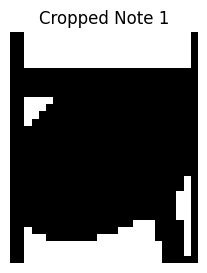

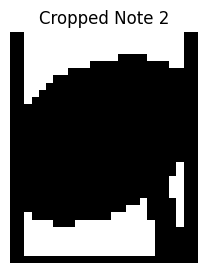

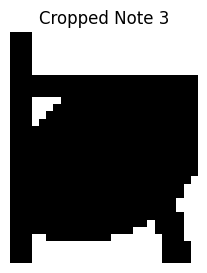

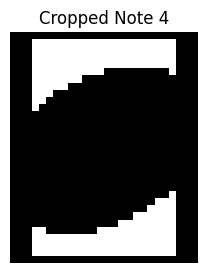

In [22]:
def crop_pad_notes(gray_img, accepted):
    H, W = gray_img.shape[:2]
    bboxes = []
    for (cx, cy), (MA, ma), _ in accepted:
        # center X, center Y
        # Major Axis - width
        # Minor axis - height
        w = int(round(MA))
        h = int(round(ma))
        x0 = max(0, int(round(cx - w/2)))
        y0 = max(0, int(round(cy - h/2)))
        x1 = min(W, int(round(cx + w/2)))
        y1 = min(H, int(round(cy + h/2)))
        bboxes.append((x0, y0, x1, y1))

    # finding universal size
    IMAGE_WIDTH, IMAGE_HEIGHT = 0,0
    for x0,y0,x1,y1 in bboxes:
        IMAGE_WIDTH = max(x1 - x0, IMAGE_WIDTH)
        IMAGE_HEIGHT = max(y1 - y0, IMAGE_HEIGHT)
    print(f"IMAGE_WIDTH: {IMAGE_WIDTH} IMAGE_HEIGHT: {IMAGE_HEIGHT}")
    padded_imgs = []
    for x0,y0, x1,y1 in bboxes:
        cropped = gray_img[y0:y1, x0:x1]
        w,h = x1 - x0, y1 - y0
        pad_w, pad_h = IMAGE_WIDTH - w, IMAGE_HEIGHT - h

        left = pad_w // 2
        right = pad_w - left
        top = pad_h // 2
        bottom = pad_h - top

        new_img = cv2.copyMakeBorder(
            cropped,
            top, bottom, left, right,
            borderType=cv2.BORDER_CONSTANT,
        )
        padded_imgs.append(new_img)
    return padded_imgs, IMAGE_WIDTH, IMAGE_HEIGHT

cropped_images, IMAGE_WIDTH, IMAGE_HEIGHT = crop_pad_notes(gray, accepted)

for idx, img in enumerate(cropped_images[:4]):
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.title(f"Cropped Note {idx+1}")
    plt.axis('off')
    plt.show()

# Preprocessing for CNN

## Filtering for images 

Finding images that contain all three classes we are looking for.

In [23]:
import re
import os 

def filtering_images(path, pattern):
    '''
    Given the OMR_XML path, it will find all images with all three notehead classes programmatically.

    We will use regex to identify `noteheadBlack`, `noteheadHalf`, `noteheadWhole` and their occurrences.
    '''
    filtered_files = {}
    for root, dirs, files in os.walk(path):
        for file in files:
            file_path = os.path.join(root, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                text_file = f.read()

            counts = len(pattern.findall(text_file))
            if counts > 3:
                filtered_files[file] = counts
            
    return filtered_files
path = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/OMR_XML"
patterns = {
    'noteheadBlack': re.compile(r'noteheadBlack'),
    'noteheadHalf':  re.compile(r'noteheadHalf'),
    'noteheadWhole': re.compile(r'noteheadWhole'),
}
for clss, pattern in patterns.items():
    files = filtering_images(path, pattern)
    print(f"{clss}")
    for file, count in files.items():
        print(f"{file}: {count}")
    print("\n")

noteheadBlack
Mendelssohn - Songs Without Words 17-layout-0-muscima.xml: 2514
Webern - Variations Op 27 III-layout-0-muscima.xml: 345
Reger - Introduction-layout-0-muscima.xml: 2901
Chopin - Etude Op 10 no 1-layout-0-muscima.xml: 1217
Bartok - Solo Violin Sonata mvt 4-layout-0-muscima.xml: 2457
Beethoven - Diabelli Variation XIV-layout-0-muscima.xml: 581
Chopin - Etude Op 10 no 11-layout-0-muscima.xml: 1983
Reger - Improvisationen 7-layout-0-muscima.xml: 2067
Bach - Goldberg Variation 16-layout-0-muscima.xml: 673
beams 4-note directions-layout-0-muscima.xml: 984
Beethoven - Diabelli Variation XXVII-layout-0-muscima.xml: 515
Reger - Improvisationen 3-layout-0-muscima.xml: 891
beam groups 12 semiquavers compound-layout-0-muscima.xml: 24576
Beethoven - Diabelli Variation XXXI-layout-0-muscima.xml: 857
syncopation 1b-layout-0-muscima.xml: 740
accidentals-layout-0-muscima.xml: 2548
accidentals grace notes-layout-0-muscima.xml: 920
beam stem weight notes 1-layout-0-muscima.xml: 900
beam grou

### Checking which images are available

In [24]:
IMAGES_DIR = '/kaggle/input/doremi-raw-dataset/DoReMi_v1/Images'
names = ["Delius", "Webern", "Schumann"]
for root, dirs, files in os.walk(IMAGES_DIR):
    for file in files:
        if any(name in file for name in names):
            print(file)

Webern - Variations Op 27 III-014.png
Delius - String Quartet mvt III-010.png
Delius - String Quartet mvt III-022.png
Schumann - String Quartet 1 mvt 3-029.png
Schumann - String Quartet 1 mvt 3-008.png
Schumann - String Quartet 1 mvt 3-003.png
Schumann - String Quartet 1 mvt 3-013.png
Schumann - String Quartet 1 mvt 3-020.png
Schumann - String Quartet 1 mvt 3-017.png
Schumann - String Quartet 1 mvt 3-004.png
Webern - Variations Op 27 III-001.png
Delius - String Quartet mvt III-036.png
Webern - Variations Op 27 III-002.png
Schumann - String Quartet 1 mvt 3-033.png
Delius - String Quartet mvt III-020.png
Schumann - String Quartet 1 mvt 3-035.png
Delius - String Quartet mvt III-009.png
Delius - String Quartet mvt III-002.png
Delius - String Quartet mvt III-034.png
Webern - Variations Op 27 III-012.png
Delius - String Quartet mvt III-029.png
Schumann - String Quartet 1 mvt 3-025.png
Webern - Variations Op 27 III-020.png
Webern - Variations Op 27 III-011.png
Schumann - String Quartet 1 mvt 

In [25]:
selected_files = [
    "Delius - String Quartet mvt III",
    "Schumann - String Quartet 1 mvt 3",
    "Webern - Variations Op 27 III"]

image_path = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/Images"

def find_images(img_dir, files):
    res = {}
    for xml in files:    
        images = []
        for root, dirs, files in os.walk(img_dir):
            for file in files:
                if file.startswith(xml):
                    images.append(file)
        res[xml] = images
    return res
    
mapping = find_images(image_path, selected_files)

In [26]:
mapping

{'Delius - String Quartet mvt III': ['Delius - String Quartet mvt III-010.png',
  'Delius - String Quartet mvt III-022.png',
  'Delius - String Quartet mvt III-036.png',
  'Delius - String Quartet mvt III-020.png',
  'Delius - String Quartet mvt III-009.png',
  'Delius - String Quartet mvt III-002.png',
  'Delius - String Quartet mvt III-034.png',
  'Delius - String Quartet mvt III-029.png',
  'Delius - String Quartet mvt III-018.png',
  'Delius - String Quartet mvt III-008.png',
  'Delius - String Quartet mvt III-013.png',
  'Delius - String Quartet mvt III-017.png',
  'Delius - String Quartet mvt III-037.png',
  'Delius - String Quartet mvt III-028.png',
  'Delius - String Quartet mvt III-014.png',
  'Delius - String Quartet mvt III-021.png',
  'Delius - String Quartet mvt III-007.png',
  'Delius - String Quartet mvt III-024.png',
  'Delius - String Quartet mvt III-031.png',
  'Delius - String Quartet mvt III-026.png',
  'Delius - String Quartet mvt III-004.png',
  'Delius - String Q

### Checking number of notehead wholes

This is more of a sanity check. There are some missing images in the dataset.

In [27]:
xml_path = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/OMR_XML/Delius - String Quartet mvt III-layout-0-muscima.xml"
tree = ET.parse(xml_path)
root = tree.getroot()

for page in root.findall('.//Page'):
    page_index = page.get("pageIndex")
    cnt = sum(1 for node in page.findall('./Nodes/Node') if node.findtext('ClassName') == 'noteheadWhole')
    if cnt == 0:
        continue
    print(f"Page {page_index}: {cnt} noteheadWhole")

Page 2: 1 noteheadWhole
Page 3: 2 noteheadWhole
Page 5: 1 noteheadWhole
Page 6: 3 noteheadWhole
Page 8: 1 noteheadWhole
Page 9: 4 noteheadWhole
Page 10: 1 noteheadWhole
Page 11: 3 noteheadWhole
Page 12: 7 noteheadWhole
Page 13: 6 noteheadWhole
Page 14: 9 noteheadWhole
Page 15: 3 noteheadWhole
Page 16: 1 noteheadWhole
Page 17: 8 noteheadWhole
Page 18: 8 noteheadWhole
Page 19: 3 noteheadWhole
Page 20: 3 noteheadWhole
Page 21: 6 noteheadWhole
Page 22: 1 noteheadWhole
Page 23: 5 noteheadWhole
Page 25: 1 noteheadWhole
Page 26: 3 noteheadWhole
Page 27: 17 noteheadWhole
Page 28: 16 noteheadWhole
Page 31: 2 noteheadWhole
Page 32: 1 noteheadWhole
Page 33: 7 noteheadWhole
Page 34: 4 noteheadWhole
Page 35: 4 noteheadWhole
Page 36: 4 noteheadWhole
Page 37: 17 noteheadWhole


### Mapping page numbers to bounding boxes 

In [28]:
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

files_to_scan = {
    "Delius - String Quartet mvt III-layout-0-muscima.xml":   "noteheadWhole",
    "Webern - Variations Op 27 III-layout-0-muscima.xml":      "noteheadBlack",
    "Schumann - String Quartet 1 mvt 3-layout-0-muscima.xml":  "noteheadHalf",
}

base_path = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/OMR_XML/"
def number_calculation(num):
    return num.zfill(3)

def iterate_xml(path, className):
    tree = ET.parse(path)
    root = tree.getroot()
    mapping = {}
    for page in root.findall('.//Page'):
        page_index = str(int(page.get("pageIndex")) + 1)
        mapping[page_index] = []
        
        for node in page.findall('./Nodes/Node'):
            if node.findtext('ClassName') == className:
                node_id = node.findtext('Id')
                top = int(node.findtext('Top'))
                left = int(node.findtext('Left'))
                width = int(node.findtext('Width'))
                height = int(node.findtext('Height'))
                mapping[page_index].append((top, left, width, height))

    return mapping
    
base_xml_dir   = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/OMR_XML/"
all_mappings   = {}

for filename, clss in files_to_scan.items():
    path = os.path.join(base_xml_dir, filename)
    all_mappings[filename] = iterate_xml(path, clss)

In [29]:
all_mappings

{'Delius - String Quartet mvt III-layout-0-muscima.xml': {'1': [],
  '2': [],
  '3': [(1128, 1725, 39, 23)],
  '4': [(1131, 891, 39, 23), (1162, 891, 39, 23)],
  '5': [],
  '6': [(1044, 489, 39, 23)],
  '7': [(1096, 530, 39, 23), (900, 744, 39, 23), (703, 744, 39, 23)],
  '8': [],
  '9': [(1109, 1322, 39, 23)],
  '10': [(1075, 1448, 39, 23),
   (1117, 1054, 39, 23),
   (1158, 1054, 39, 23),
   (920, 1054, 39, 23)],
  '11': [(1136, 489, 39, 23)],
  '12': [(1132, 1416, 39, 23), (925, 1416, 39, 23), (714, 1416, 39, 23)],
  '13': [(1127, 1416, 39, 23),
   (1127, 489, 39, 23),
   (879, 1416, 39, 23),
   (931, 1416, 39, 23),
   (920, 489, 39, 23),
   (724, 489, 39, 23),
   (455, 1416, 39, 23)],
  '14': [(1208, 1416, 39, 23),
   (1239, 1416, 39, 23),
   (1208, 489, 39, 23),
   (1239, 489, 39, 23),
   (992, 1416, 39, 23),
   (992, 489, 39, 23)],
  '15': [(1121, 1422, 39, 23),
   (1173, 1422, 39, 23),
   (1131, 489, 39, 23),
   (1173, 489, 39, 23),
   (925, 1422, 39, 23),
   (935, 489, 39, 23),

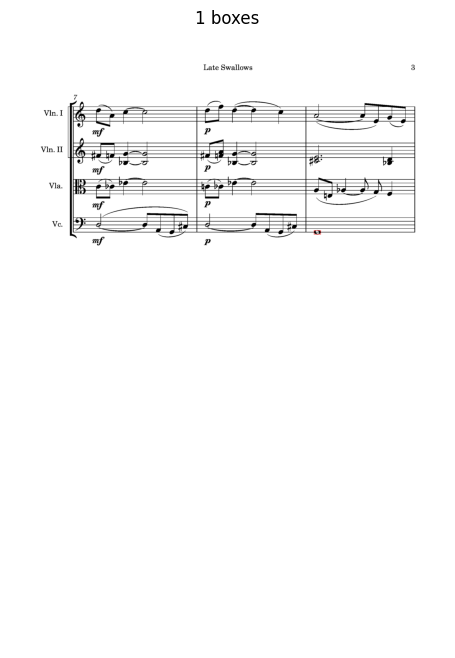

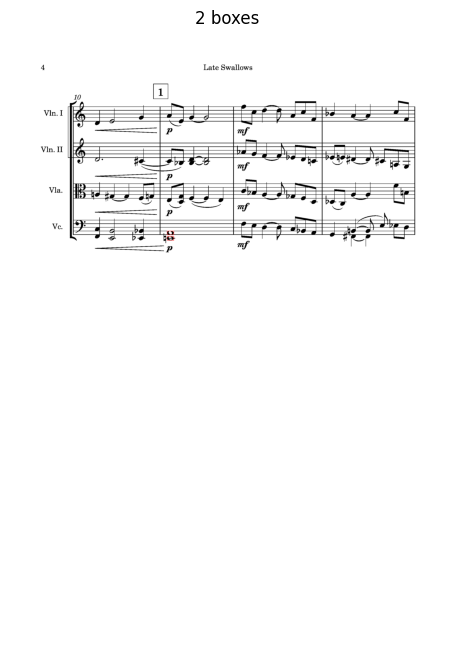

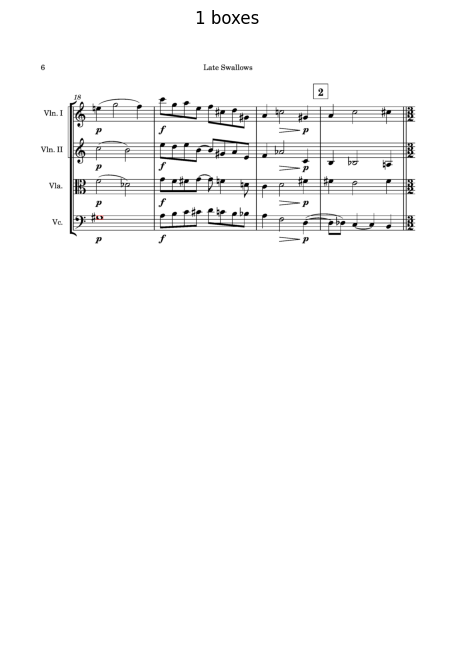

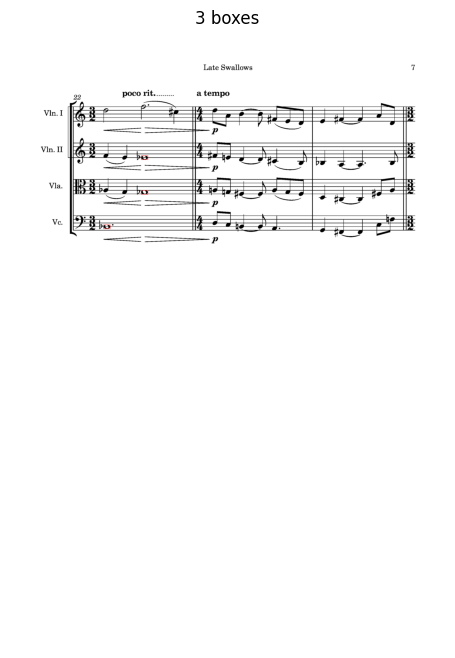

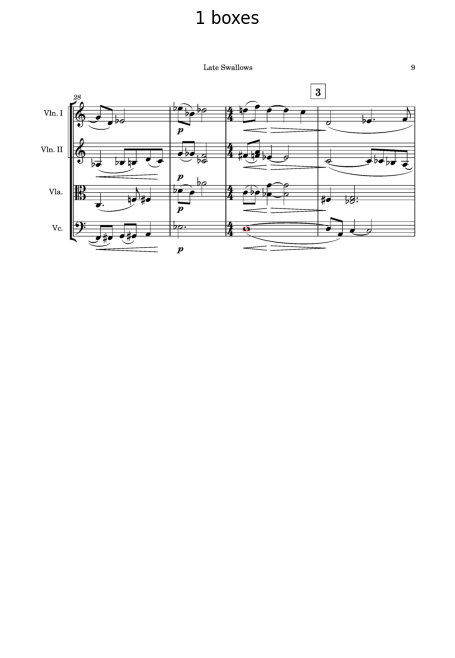

In [30]:
# from PIL import Image, ImageDraw

prefixes = [
    "Delius - String Quartet mvt III",
    "Webern - Variations Op 27 III",
    "Schumann - String Quartet 1 mvt"
]

image_base_path = "/kaggle/input/doremi-raw-dataset/DoReMi_v1/Images/"
def drawing_notes(mapping, prefix, max_images = 5):
    for page, notes in mapping.items():
        if max_images == 0:
            break
        if len(notes) == 0:
            continue

        page_number = number_calculation(page)
        img_name = f"{prefix}-{page_number}.png"
        if not os.path.isfile(img_name):
            print(f"{img_name} not found, skipping")
            continue
            
        img  = Image.open(img_name)
        draw = ImageDraw.Draw(img)
        
        for top, left, width, height in notes:
            x0, y0 = left, top
            x1, y1 = left + width, top + height
            draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
        
        plt.figure(figsize=(10,8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{len(notes)} boxes")
        plt.show()
        max_images -= 1

for mapping, prefix in zip(all_mappings.values(), prefixes):
    drawing_notes(mapping, image_base_path + prefix)
    break

# Building Dataframe

Here we will build the dataframe to be passed into our CNN model with the data being individual noteheads and the labels being the one hot encoded class names.  

In the first iteration of the project, we only care about the three clases, `noteheadBlack`, `noteheadHalf` and `noteheadWhole`. Therefore, we handpicked some images that contain all three types of notes and cropped for the sole purpose of training our CNN of identifying notes.

In [31]:
import os
import numpy as np
import pandas as pd
from PIL import Image

TARGET_SIZE = (39, 23)

def crop_notes(mapping, image_prefix, class_name):
    data, labels = [],[]
    for page, bboxes in mapping.items():
        img_path = f"{image_prefix}{number_calculation(page)}.png"
        if not os.path.exists(img_path) or len(bboxes) == 0:
            continue
        # print(f"{page}: has {len(bboxes)}")
        img = Image.open(img_path)
        for top, left, width, height in bboxes:
            crop = img.crop((left, top, left + width, top + height))
            crop = crop.resize(TARGET_SIZE)
            data.append(np.array(crop))
            labels.append(class_name)
    return data, labels

all_data, all_labels = [], []
for filename, class_name in files_to_scan.items():
    mmap = all_mappings[filename]
    prefix = image_base_path + filename.replace('-layout-0-muscima.xml','-')
    data, labels = crop_notes(mmap, prefix, class_name)
    all_data.extend(data)
    all_labels.extend(labels)

df = pd.DataFrame({
    'image': all_data,
    'label': all_labels
})

print(df.head())

                                               image          label
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...  noteheadWhole
1  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...  noteheadWhole
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...  noteheadWhole
3  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...  noteheadWhole
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...  noteheadWhole


# Cleaning Data

We want equal number of noteheads per class, 150 each, so there is no bais in our training data.

In [32]:
def display_image(image, title="Image"):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

Dimensions: height 23, width 39


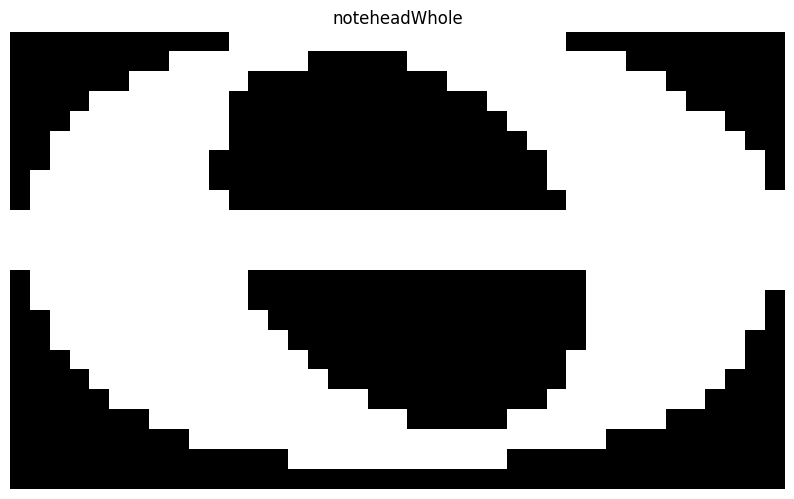

Dimensions: height 23, width 39


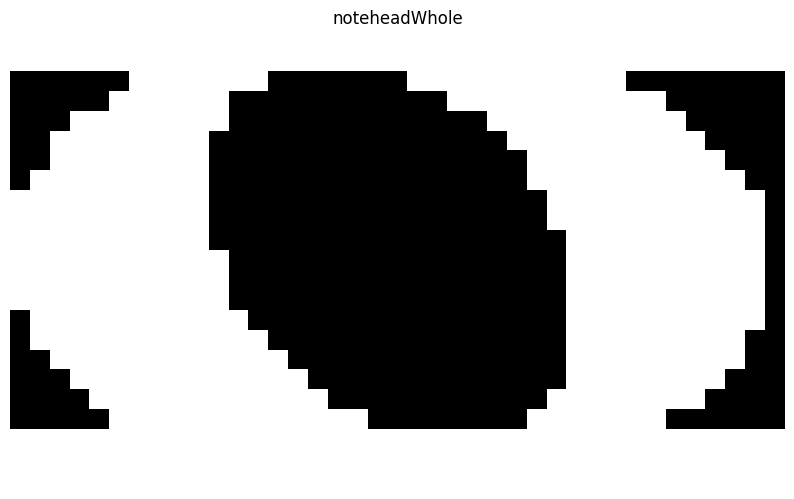

Dimensions: height 23, width 39


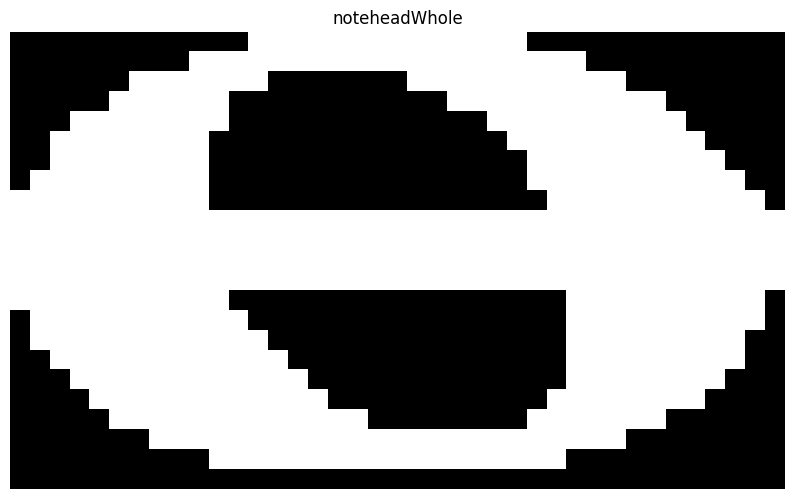

Dimensions: height 23, width 39


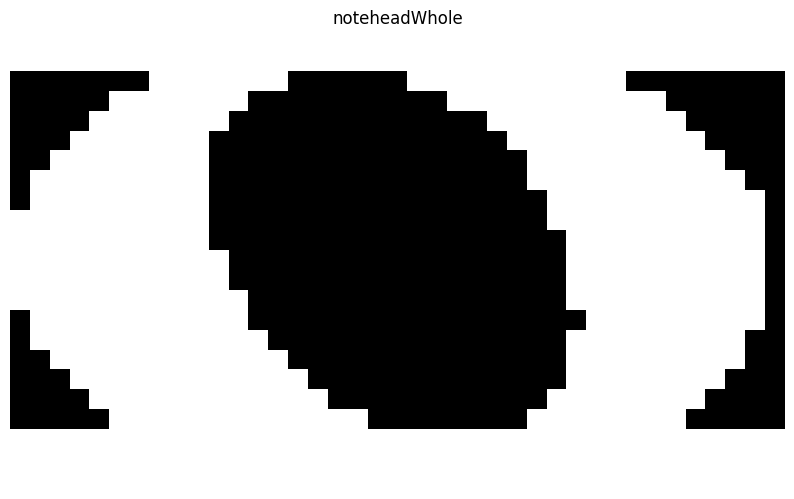

Dimensions: height 23, width 39


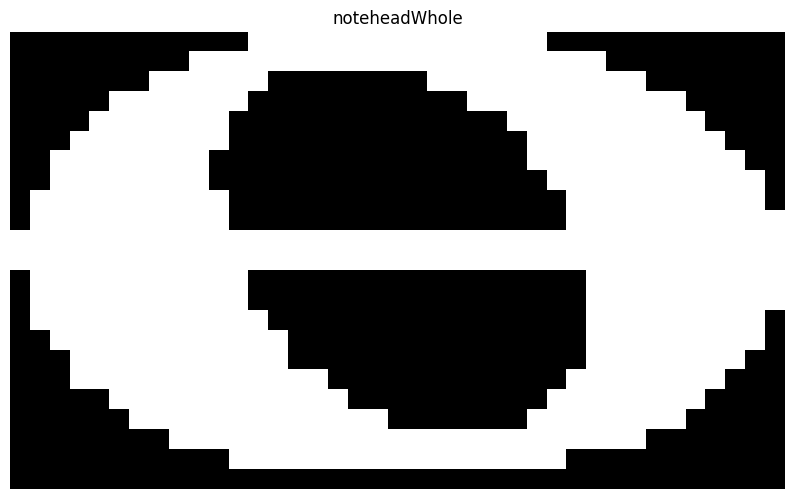

In [33]:
for idx, row in df.head(5).iterrows():
    image = row['image']
    H, W = image.shape[:2]
    print(f"Dimensions: height {H}, width {W}")
    display_image(image, row['label'])


In [34]:
n_classes = df['label'].nunique()
print(f"{n_classes} classes")

print(df['label'].value_counts())

3 classes
label
noteheadBlack    304
noteheadHalf     150
noteheadWhole    124
Name: count, dtype: int64


### Slicing `noteheadBlack` 

Reducing the number of `noteheadBlack` classes to ~150 so that the model data isn't biased.

In [35]:
# Slicing
df_black = df[df['label'] == 'noteheadBlack'].iloc[:150]
df_others = df[df['label'] != 'noteheadBlack']

# Recombining
df_trunc = pd.concat([df_others, df_black], ignore_index=True)

print(df_trunc['label'].value_counts())

label
noteheadHalf     150
noteheadBlack    150
noteheadWhole    124
Name: count, dtype: int64


### Encoding labels

In [36]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_trunc['label_encoded'] = encoder.fit_transform(df_trunc["label"])

print(f"Classes to labels", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))
print(df_trunc['label_encoded'])

Classes to labels {'noteheadBlack': 0, 'noteheadHalf': 1, 'noteheadWhole': 2}
0      2
1      2
2      2
3      2
4      2
      ..
419    0
420    0
421    0
422    0
423    0
Name: label_encoded, Length: 424, dtype: int64


In [37]:
from sklearn.model_selection import train_test_split

X = df_trunc["image"].tolist()
X = np.stack(X) # Stacking arrays into a tensor

print("Data shape", X.shape)

y = df_trunc["label_encoded"].values

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size = 0.2, # 80/20 split
    stratify=y, # Need equal parts of each class in each
    random_state=42
)
print("Train class distribution:", np.bincount(y_train))
print("Test  class distributino:", np.bincount(y_test))

Data shape (424, 23, 39)
Train class distribution: [120 120  99]
Test  class distributino: [30 30 25]


# CNN Architecture

Here, we will pass in the cropped noteheads into our CNN model to do multiclass classification, determining if the notes are `noteheadBlack`, `noteheadHalf`, and `noteheadWhole`.

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

IMAGE_SHAPE = (39, 23, 1)
CLASSES = 3
cnn_model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SHAPE),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    # Second Convolutional layer
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
   # Fully connect classifier
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # For single label classification (one label per image)
    Dense(CLASSES, activation='softmax')
])

cnn_model.summary()
cnn_model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

2025-04-28 21:11:51.751679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745874711.992887      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745874712.061450      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-28 21:12:07.505620: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 37, 21, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 37, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 18, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 8, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 8, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,859 (1.08 MB)

 Trainable params: 281,667 (1.07 MB)

 Non-trainable params: 192 (768.00 B)

## Training

In [39]:
result = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8045 - loss: 0.8475 - val_accuracy: 0.6471 - val_loss: 0.7451
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 9.8289e-07 - val_accuracy: 0.6471 - val_loss: 0.6631
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 7.8363e-07 - val_accuracy: 0.6471 - val_loss: 0.6387
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 3.4325e-06 - val_accuracy: 0.6471 - val_loss: 0.6112
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 3.0914e-06 - val_accuracy: 0.6471 - val_loss: 0.5906
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 1.6023e-07 - val_accuracy: 0.6471 - val_loss: 0.5521
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 2.7515e-06 - val_accuracy: 0.6471 - val_loss: 0.5062
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 3.4417e-0

In [44]:
cnn_model.save("cnn_model.h5")

## Testing

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


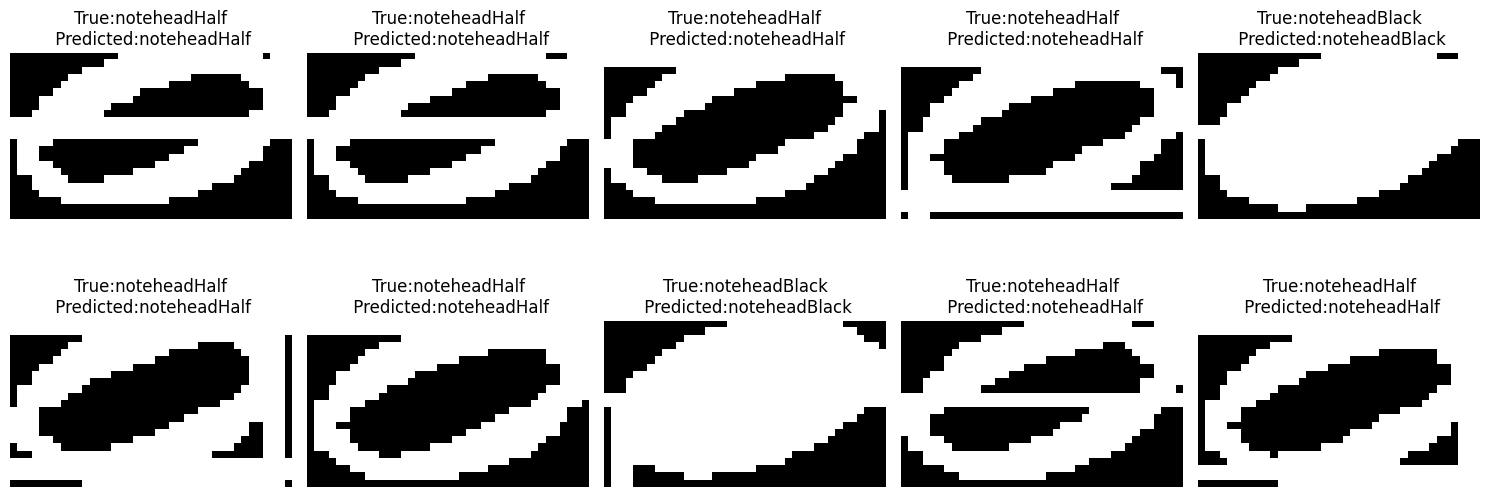

In [40]:
import matplotlib.pyplot as plt

probs = cnn_model.predict(X_test) # predicting on test set
predicted = np.argmax(probs, axis=1) # selecting highest prob

# reverting back from labels
p_labels = encoder.inverse_transform(predicted) 
t_labels = encoder.inverse_transform(y_test)

# 2×5 grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = X_test[i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True:{t_labels[i]}\n Predicted:{p_labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Calculating Pitch

Given the note location, unit intervals of a staffline and staffline position, we can calculate the pitches of notes.

inputs are staff class for ymin and ymax, I'm taking in the cropped notehead stuff from above 

In [41]:
def calculate_pitch(cy, staff_center, unit_size):
    pitch_step = round(-(cy - staff_center) / (unit_size / 2))
    
    pitch_names = {
    -20: "C", -19: "D", -18: "E", -17: "F", -16: "G",
    -15: "A", -14: "B", -13: "C", -12: "D", -11: "E",
    -10: "F",  -9: "G",  -8: "A",  -7: "B",  -6: "C",
     -5: "D",  -4: "E",  -3: "F",  -2: "G",  -1: "A",
      0: "B",   1: "C",   2: "D",   3: "E",   4: "F",
      5: "G",   6: "A",   7: "B",   8: "C",   9: "D",
     10: "E",  11: "F",  12: "G",  13: "A",  14: "B",
     15: "C",  16: "D",  17: "E",  18: "F",  19: "G",
     20: "A"
    }


    pitch = pitch_names.get(pitch_step, "Unknown")
    return pitch, pitch_step

In [42]:
staff_center = staff_objects[0].center
unit_size = staff_objects[0].unit_size
print(staff_center)
cropped_offset = max_upper

for (cx, cy), (MA, ma), ang in accepted:
    cy_full = cy + cropped_offset
    
    pitch, step = calculate_pitch(cy_full, staff_center, unit_size)
    print(f"Note at y={cy:.1f}: Pitch = {pitch}, Step = {step}")

465.4
Note at y=300.9: Pitch = A, Step = -15
Note at y=292.5: Pitch = B, Step = -14
Note at y=280.5: Pitch = C, Step = -13
Note at y=208.7: Pitch = C, Step = -6
Note at y=209.0: Pitch = C, Step = -6
Note at y=208.8: Pitch = C, Step = -6
Note at y=199.6: Pitch = D, Step = -5
Note at y=199.6: Pitch = D, Step = -5
Note at y=200.1: Pitch = D, Step = -5
Note at y=199.8: Pitch = D, Step = -5
Note at y=199.9: Pitch = D, Step = -5
Note at y=200.1: Pitch = D, Step = -5
Note at y=200.0: Pitch = D, Step = -5
Note at y=199.6: Pitch = D, Step = -5
Note at y=198.1: Pitch = D, Step = -5
Note at y=198.5: Pitch = D, Step = -5
Note at y=199.4: Pitch = D, Step = -5
Note at y=158.2: Pitch = A, Step = -1
Note at y=146.3: Pitch = B, Step = 0
Note at y=135.9: Pitch = C, Step = 1
Note at y=116.2: Pitch = E, Step = 3
Note at y=106.1: Pitch = F, Step = 4
Note at y=106.0: Pitch = F, Step = 4
Note at y=105.8: Pitch = F, Step = 4
Note at y=106.0: Pitch = F, Step = 4
Note at y=105.8: Pitch = F, Step = 4
Note at y=1

NameError: name 'gray_full' is not defined

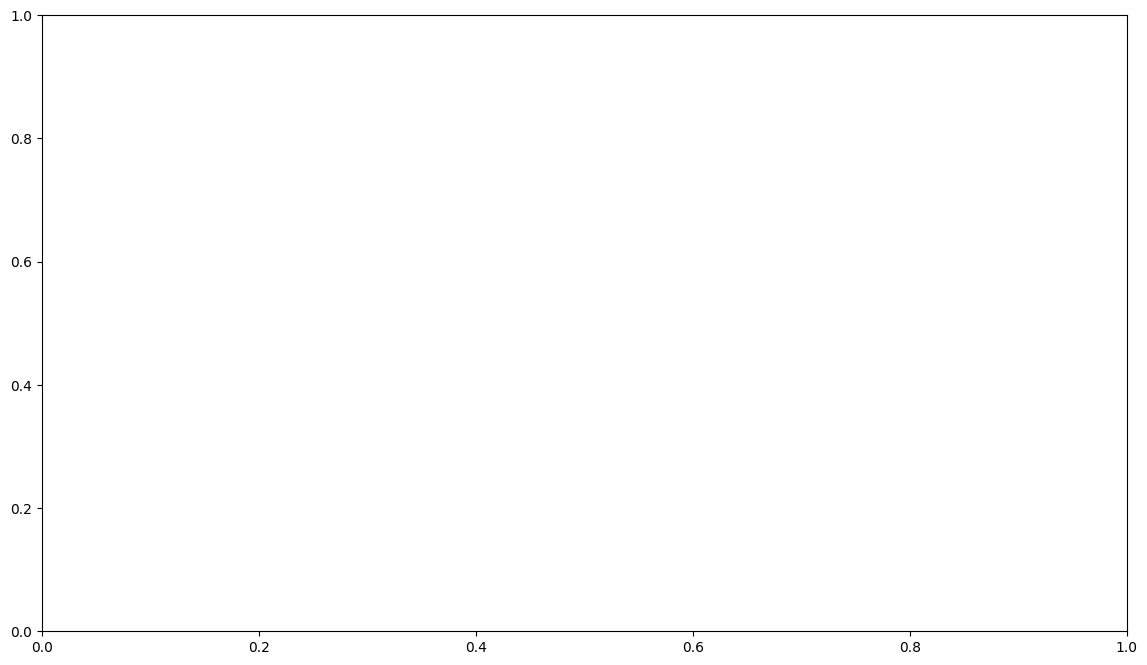

In [43]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.imshow(gray_full, cmap='gray')
ax.set_title("Note Positions with Pitches")

for idx, ((cx, cy), (MA, ma), ang) in enumerate(accepted):
    cy_full = cy + cropped_offset
    pitch, step = calculate_pitch(cy_full, staff_center, unit_size)

    circ = plt.Circle((cx, cy_full), radius=5, color='red', fill=True)
    ax.add_patch(circ)

    offset_y = 20 if idx % 2 == 0 else -20
    ax.text(cx + 10, cy_full + offset_y, f"{pitch}",
            color='blue', fontsize=9, verticalalignment='center')

ax.axhline(staff_center, color='green', linestyle='--', label=f'Staff Center (Y={staff_center:.1f})')
ax.legend()
plt.axis('off')
plt.show()





# Final Putting Everything Together